# CASE: Every 1 day a 50 % of the premium obtained is withdrawn

### Libraries import

In [1]:
import random
import sys
from ntpath import join
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
import pandas as pd
from IPython.display import display, HTML

### Base scenario values

In [2]:
NUM_SIM = 100
MAX_NUMBER_INVOICES = 500
MIN_PERC_NOT_COLLATERALIZED = 0.05
MAX_PERC_NOT_COLLATERALIZED = 0.49
MIN_INVOICE_REQ_NOT_COL = 100
MAX_INVOICE_REQ_NOT_COL = 2000
PROB_HACK = 0.0
PROB_UNPAID = 0.00 + PROB_HACK
PROB_ADD_LIQUIDITY = 0.0
MIN_LIQUIDITY_ADD = 0
MAX_LIQUIDITY_ADD = 0
MAX_DELAY_INVOICE = 120
MIN_DELAY_INVOICE = 30
MAX_DAYS = 500
ADDITIONAL_DAYS = 30
MAX_DAYS_SIM = MAX_DAYS + MAX_DELAY_INVOICE + ADDITIONAL_DAYS
START_Q_LIQUIDITY = 10000
START_PREM_LIQUIDITY = 0
INITIAL_TOTAL_VOLUME = START_Q_LIQUIDITY + START_PREM_LIQUIDITY

### Premium withdrawn configuration

In [3]:
PREMIUM_WITHDRAW_DAYS = 1 #From 0 to (MAX_DAYS_SIM OR MAX_NUMBER_INVOICES)
PREMIUM_FACTOR = 0.5 # % of premium to withdraw

### Scenario reset function

In [4]:
def reset():
    global PROB_ADD_LIQUIDITY
    global MIN_LIQUIDITY_ADD
    global MAX_LIQUIDITY_ADD
    PROB_ADD_LIQUIDITY = MIN_LIQUIDITY_ADD = MAX_LIQUIDITY_ADD = 0
    global MIN_DELAY_INVOICE
    global MAX_DELAY_INVOICE
    MIN_DELAY_INVOICE, MAX_DELAY_INVOICE = 30, 120
    global PROB_UNPAID
    PROB_UNPAID = 0
    global MIN_INVOICE_REQ_NOT_COL
    global MAX_INVOICE_REQ_NOT_COL
    MIN_INVOICE_REQ_NOT_COL, MAX_INVOICE_REQ_NOT_COL = 100, 2000
    global MIN_PERC_NOT_COLLATERALIZED
    global MAX_PERC_NOT_COLLATERALIZED
    MIN_PERC_NOT_COLLATERALIZED, MAX_PERC_NOT_COLLATERALIZED = 0.05, 0.49

### Scenario functions

In [5]:
def scenario_1(prob_add_liq, perc_liq_add):
    global PROB_ADD_LIQUIDITY
    global MIN_LIQUIDITY_ADD
    global MAX_LIQUIDITY_ADD
    PROB_ADD_LIQUIDITY, MIN_LIQUIDITY_ADD, MAX_LIQUIDITY_ADD = prob_add_liq, 0, perc_liq_add*START_Q_LIQUIDITY
    print(f"Scenario 1: Increasing Liquidity Through Time with prob. {prob_add_liq*100} % of adding {100*perc_liq_add} % of initial liquidity")

def scenario_2(prob_unpaid):
    global PROB_UNPAID
    PROB_UNPAID = prob_unpaid
    print(f"Scenario 2: More and more Unpaid Invoices. {100*prob_unpaid} % of unpaid invoices")
    
def scenario_3(min_invoice_delay, max_invoice_delay):
    global MIN_DELAY_INVOICE
    global MAX_DELAY_INVOICE
    MIN_DELAY_INVOICE, MAX_DELAY_INVOICE = min_invoice_delay, max_invoice_delay
    print(f"Scenario 3: More and more Delay in the Invoice Payments. Min delay: {min_invoice_delay} days, Max delay: {max_invoice_delay} days")
    
def scenario_4(invoice_amount_not_col):
    global MIN_INVOICE_REQ_NOT_COL
    global MAX_INVOICE_REQ_NOT_COL
    MIN_INVOICE_REQ_NOT_COL = MAX_INVOICE_REQ_NOT_COL = invoice_amount_not_col*START_Q_LIQUIDITY
    print(f"Scenario 4: Playing with Growing Invoices, therefore growing demanded collateral. Demanded collateral: {100*invoice_amount_not_col} % of initial Q")
    
def scenario_5(invoice_col):
    global MIN_PERC_NOT_COLLATERALIZED
    global MAX_PERC_NOT_COLLATERALIZED
    MAX_PERC_NOT_COLLATERALIZED = MIN_PERC_NOT_COLLATERALIZED = 1-invoice_col
    print(f"Scenario 5: Playing with Growing % of Collateral with a Same Invoice amount. {round(100*invoice_col, 0)} %  collateralized")
    
def hack_scenario(prob_hack, invoice_col):
    global PROB_UNPAID
    global MIN_PERC_NOT_COLLATERALIZED
    global MAX_PERC_NOT_COLLATERALIZED
    global MIN_INVOICE_REQ_NOT_COL
    global MAX_INVOICE_REQ_NOT_COL
    PROB_UNPAID = prob_hack
    MAX_PERC_NOT_COLLATERALIZED = MIN_PERC_NOT_COLLATERALIZED = 1-invoice_col
    print(f"Hack Scenario. Hack prob. {100*prob_hack} % with invoices {100*invoice_col} % collateralized")

### Plot aux function

In [6]:
def aux_plot():
    fig = plt.figure(figsize=(15, 25))

    y = np.arange(0, MAX_DAYS_SIM+1, 1, dtype=int)
    plt.rcParams["figure.figsize"] = (20,10)

    ax = fig.add_subplot(411)
    ax2 = fig.add_subplot(412)
    ax3 = fig.add_subplot(413)
    ax4 = fig.add_subplot(414)

    ax.set_title('AMM Q Volume', fontsize=15)
    ax.set_xlabel('Days', fontsize=15)
    ax.set_ylabel('Volume', fontsize=15) 
    ax.set_xlim([0, len(y)])

    ax2.set_title('Premium', fontsize=15)
    ax2.set_xlabel('Days', fontsize=15)
    ax2.set_ylabel('Prem', fontsize=15) 
    ax2.set_xlim([0, len(y)])

    ax3.set_title('Total Volume (Q + Prem)', fontsize=15)
    ax3.set_xlabel('Days', fontsize=15)
    ax3.set_ylabel('Total Volume', fontsize=15) 
    ax3.set_xlim([0, len(y)])
    
    ax4.set_title('Withdrawn Premium', fontsize=15)
    ax4.set_xlabel('Days', fontsize=15)
    ax4.set_ylabel('Prem', fontsize=15) 
    ax4.set_xlim([0, len(y)])
    
    return ax, ax2, ax3, ax4, y

### Auxiliary result structures

In [7]:
sim_type = ['no_premium_withdrawn', 'premium_withdrawn']

results_params = {
        'collateralized_counter': '',
        'unpaid_invoices': '',
        'unpaid_amount': '',
        'paid_invoices': '',
        'collateralized_amount': '',
        'sum_q_amount': '',
        'total_premium': '',
        'total_volume': '',
        'array_q_volume': '',
        'array_prem': '',
        'array_vol': '',
        'unavailable_days': '',
        'array_accu_prem': '',
        'gain': ''
    }

results_dict = {
    sim_type[0]: results_params,
    sim_type[1]: results_params,
}

### Simulation auxiliary functions

In [8]:
def unpaid_delayed_aux(prob_unpaid):
    probability_delayed = random.random() > prob_unpaid
    if probability_delayed:
        return random.randint(MIN_DELAY_INVOICE, MAX_DELAY_INVOICE)
    else:
        return 100000

def generate_invoices():
    invoices_list = []
    for i in range(0, MAX_NUMBER_INVOICES):
        delay_days = unpaid_delayed_aux(PROB_UNPAID)

        invoices_list.append({
            'id':i,
            'q':round(random.uniform(MIN_PERC_NOT_COLLATERALIZED,MAX_PERC_NOT_COLLATERALIZED), 2),
            'q_amount': random.randint(MIN_INVOICE_REQ_NOT_COL, MAX_INVOICE_REQ_NOT_COL),
            'delay_days': delay_days,
            'col_when': 0,
            'collateralized': False,
            'paid': False
        })

    return invoices_list

def modify_liquidity_q(amount, total_q_volume):
    total_q_volume += amount
    return total_q_volume

def modify_volume(amount, total_volume):
    total_volume += amount
    return total_volume

def modify_premium(amount, total_premium):
    total_premium += amount
    return total_premium

def get_premium(q_amount, q, total_q_volume, total_premium):
    volume = total_q_volume + total_premium
    prem = round(q*q/(1-q*(1+q_amount/(volume)))*q_amount, 2)
    return prem

def rkAMM(sim_type, PREMIUM_FLAG):
    invoices =  generate_invoices()
    sum_q_amount = 0
    for i in range(len(invoices)):
        sum_q_amount += list(invoices[i].values())[2]
        #print(invoices[i])
    #print("Total collateral to afford", sum_q_amount)
    
    total_premium = START_PREM_LIQUIDITY
    accumulated_premium = START_PREM_LIQUIDITY
    total_q_volume = START_Q_LIQUIDITY
    total_volume = total_premium + total_q_volume
    paid_counter = 0
    collateralized_counter = 0
    collateralized_amount = 0
    unpaid_amount = 0
    unavailable_days = 0
    profit = 0

    array_q_volume = [total_q_volume]
    array_premium = [0]
    array_volume = [total_volume]
    array_accu_premium = [0]

    for i in range(0, MAX_DAYS_SIM):
        prob_liq_added = random.random() < PROB_ADD_LIQUIDITY

        if prob_liq_added:
            liq_added = random.randint(MIN_LIQUIDITY_ADD, MAX_LIQUIDITY_ADD)
            total_q_volume = modify_liquidity_q(liq_added, total_q_volume)
            total_volume = total_q_volume + total_premium
        
        try:
            q = invoices[i]['q']
            q_amount = invoices[i]['q_amount']

            if(total_q_volume >= invoices[i]['q_amount'] and i < len(invoices) and invoices[i]['collateralized'] == False):
                prem = get_premium(invoices[i]['q_amount'], q, total_q_volume, total_premium)
                total_premium = modify_premium(prem, total_premium)
                total_q_volume = modify_liquidity_q(-invoices[i]['q_amount'], total_q_volume)
                total_volume = total_q_volume + total_premium
                                    
                collateralized_counter += 1
                invoices[i]['collateralized'] = True
                invoices[i]['col_when'] = i

                collateralized_amount += invoices[i]['q_amount']
                unpaid_amount += invoices[i]['q_amount']
                
            elif(total_q_volume < invoices[i]['q_amount'] and total_volume > invoices[i]['q_amount'] and i < len(invoices) and invoices[i]['collateralized'] == False):
                
                prem = get_premium(invoices[i]['q_amount'], q, total_q_volume, total_premium)
                total_premium = modify_premium(prem, total_premium)
                
                partial_q_amount = invoices[i]['q_amount'] - total_q_volume
                total_premium = modify_premium(-partial_q_amount, total_premium)
                total_q_volume = 0
                
                total_volume = total_q_volume + total_premium
                
                collateralized_counter += 1
                invoices[i]['collateralized'] = True
                invoices[i]['col_when'] = i

                collateralized_amount += invoices[i]['q_amount']
                unpaid_amount += invoices[i]['q_amount']
            else:
                unavailable_days += 1
                    
            for j in invoices:
                if(i - j['col_when'] == j['delay_days'] and j['collateralized'] == True):
                    total_q_volume = modify_liquidity_q(j['q_amount'], total_q_volume)
                    j['paid'] = True
                    paid_counter += 1
                    unpaid_amount -= j['q_amount']
                
        except:
            for j in invoices:
                if(i - j['col_when'] == j['delay_days'] and j['collateralized'] == True):
                    total_q_volume = modify_liquidity_q(j['q_amount'], total_q_volume)
                    j['paid'] = True
                    paid_counter += 1
                    unpaid_amount -= j['q_amount']
        
        if PREMIUM_FLAG and (i % PREMIUM_WITHDRAW_DAYS == 0) and total_premium > 0:
            accumulated_premium += PREMIUM_FACTOR*total_premium
            total_premium = modify_premium(-PREMIUM_FACTOR*total_premium, total_premium)
        
        array_q_volume.append(total_q_volume)
        array_premium.append(total_premium)
        total_volume = total_q_volume + total_premium
        array_volume.append(total_volume)
        array_accu_premium.append(accumulated_premium)
        profit = (total_q_volume + total_premium - START_Q_LIQUIDITY) + (accumulated_premium)

    values_for_dict = [collateralized_counter, (collateralized_counter-paid_counter), unpaid_amount, paid_counter, collateralized_amount, sum_q_amount, total_premium, total_volume, array_q_volume, array_premium, array_volume, unavailable_days, array_accu_premium, profit]
    for index, key in enumerate(results_dict[sim_type].keys()):
        results_dict[sim_type][key] = values_for_dict[index]

    return collateralized_counter, (collateralized_counter-paid_counter), unpaid_amount, paid_counter, collateralized_amount, sum_q_amount, total_premium, total_volume, array_q_volume, array_premium, array_volume, unavailable_days, array_accu_premium, profit

### Result generation function

In [9]:
def result():
    
    col, imp, total_loss, paid, total_to_col, total_q, total_prem, total_vol, array_q_vol, array_prem, array_vol, un_days, array_accu_prem, gain = ([] for i in range(14))
    arr_q_volume_values, arr_prem_values, arr_volume_values, arr_accu_prem_values = ([] for i in range(4))

    df = pd.DataFrame()

    for index, simulation in enumerate(sim_type):
        if(simulation == 'no_premium_withdrawn'):
            PREMIUM_FLAG = False
        elif(simulation == 'premium_withdrawn'):
            PREMIUM_FLAG = True
        else:
            print("Error")
            break
        
        for i in range(0, NUM_SIM):
            results = rkAMM(simulation, PREMIUM_FLAG)
                        
            col.append(results_dict[simulation]['collateralized_counter'])
            imp.append(results_dict[simulation]['unpaid_invoices'])
            total_loss.append(results_dict[simulation]['unpaid_amount'])
            paid.append(results_dict[simulation]['paid_invoices'])
            total_to_col.append(results_dict[simulation]['collateralized_amount'])
            total_q.append(results_dict[simulation]['sum_q_amount'])
            total_prem.append(results_dict[simulation]['total_premium'])
            total_vol.append(results_dict[simulation]['total_volume'])
            array_q_vol.append(results_dict[simulation]['array_q_volume']) 
            array_prem.append(results_dict[simulation]['array_prem'])
            array_vol.append(results_dict[simulation]['array_vol'])
            un_days.append(results_dict[simulation]['unavailable_days'])
            array_accu_prem.append(results_dict[simulation]['array_accu_prem'])
            gain.append(results_dict[simulation]['gain'])

        array_q_vol = [sum(x) for x in zip(*array_q_vol)]
        q_volume_values = [x / NUM_SIM for x in array_q_vol]

        array_prem = [sum(x) for x in zip(*array_prem)]
        prem_values = [x / NUM_SIM for x in array_prem]

        array_vol = [sum(x) for x in zip(*array_vol)]
        volume_values = [x / NUM_SIM for x in array_vol]

        array_accu_prem = [sum(x) for x in zip(*array_accu_prem)]
        accu_prem_values = [x / NUM_SIM for x in array_accu_prem]

        data_names = ["Number of simulations", "Simulation time period (days)", "Total of invoices", "Average of accepted invoices (collateralized)", "% of accepted invoices (collateralized)", "Average of paid invoices (capital returned)", "% of paid invoices (capital returned)", "Average of unpaid invoices (capital not returned)", "% of unpaid invoices (capital not returned)", "Average loss due to unpaid invoices", "Total collateral covered", "Total collateral covered x (i.c.)", "Total premium withdrawn", "Total premium withdrawn x (i.c.)", "Remaining AMM premium", "Remaining AMM premium x (i.c.)", "Final AMM volume", "AMM profit", "AMM profit percentage"]

        data = [
            ["Number of simulations", int(NUM_SIM)],
            ["Simulation time period (days)", int(MAX_DAYS_SIM)],
            ["Total of invoices", int(MAX_NUMBER_INVOICES)],
            ["Average of accepted invoices (collateralized)", round(sum(col)/NUM_SIM, 2)],
            ["% of accepted invoices (collateralized)", round((100*sum(col)/NUM_SIM)/MAX_NUMBER_INVOICES, 2)],
            ["Average of paid invoices (capital returned)", round(sum(paid)/NUM_SIM, 2)],
            ["% of paid invoices (capital returned)", round((100*sum(paid)/NUM_SIM)/(sum(col)/NUM_SIM), 2)],
            ["Average of unpaid invoices (capital not returned)", round(sum(imp)/NUM_SIM, 2)],
            ["% of unpaid invoices (capital not returned)", round((100*sum(imp)/NUM_SIM)/(sum(col)/NUM_SIM), 2)],
            ["Average loss due to unpaid invoices", round(sum(total_loss)/NUM_SIM, 2)],
            ["Total collateral covered", round(sum(total_to_col)/NUM_SIM, 2)],
            ["Total collateral covered x (i.c.)", round((sum(total_to_col)/NUM_SIM)/START_Q_LIQUIDITY, 2)],
            ["Total premium withdrawn", round((array_accu_prem[len(array_accu_prem)-1])/NUM_SIM, 2)],
            ["Total premium withdrawn x (i.c.)", round(round((array_accu_prem[len(array_accu_prem)-1])/NUM_SIM, 2)/START_Q_LIQUIDITY, 2)],
            ["Remaining AMM premium", round(sum(total_prem)/NUM_SIM, 2)],
            ["Remaining AMM premium x (i.c.)", round(round(sum(total_prem)/NUM_SIM, 2)/START_Q_LIQUIDITY, 2)],
            ["Final AMM volume", round(sum(total_vol)/NUM_SIM, 2)],
            ["AMM profit", round((sum(gain)/NUM_SIM), 2)],
            ["% AMM profit", round((sum(gain)/NUM_SIM)*100 / INITIAL_TOTAL_VOLUME, 2)],
        ] 
    
        arr_q_volume_values.append(q_volume_values)
        arr_prem_values.append(prem_values)
        arr_volume_values.append(volume_values)
        arr_accu_prem_values.append(accu_prem_values)   

        df1 = pd.DataFrame()
        df1 = pd.DataFrame(data[0:], columns=data[0])
        df1 = df1.drop(df1.columns[[0]], axis = 1)
        df[index] = df1
    
        col, imp, total_loss, paid, total_to_col, total_q, total_prem, total_vol, array_q_vol, array_prem, array_vol, un_days, array_accu_prem, gain = ([] for i in range(14))
        
    df.columns = ['No Premium Withdrawn', 'Premium Withdrawn']
    df.insert(loc = 0, column = 'Description', value = data_names)
    df.insert(loc = 3, column = "Premium vs. No Premium Withdrawn", value = round((df['Premium Withdrawn']/df['No Premium Withdrawn'] - 1) * 100, 2))
    df.fillna(0, inplace=True)
    df.replace([-np.inf, np.inf], [-100, 100], inplace=True)
           
    df['No Premium Withdrawn'] = df['No Premium Withdrawn'].apply('{:,}'.format)
    df['Premium Withdrawn'] = df['Premium Withdrawn'].apply('{:,}'.format)

    df['No Premium Withdrawn'] = df['No Premium Withdrawn'].astype(str)
    df['Premium Withdrawn'] = df['Premium Withdrawn'].astype(str)
    df['Premium vs. No Premium Withdrawn'] = df['Premium vs. No Premium Withdrawn'].astype(str) + '%'
    
    pd.options.display.float_format = '{:,.2f}'.format
    
    display(df)
    
    pd.reset_option('display.float_format')
        
    return arr_q_volume_values, arr_prem_values, arr_volume_values, arr_accu_prem_values

### Values for each scenario

In [10]:
values_scenario1 = [(0.5, 0.01), (0.5, 0.05), (0.5, 0.1), (0.5, 0.25)]
values_scenario2 = [0.02, 0.05, 0.2]
values_scenario3 = [(30, 60), (60, 90), (90, 120)]
values_scenario4 = [0.01, 0.1, 0.25]
values_scenario5 = [0.55, 0.75, 0.9]
values_hack_scenario = [(0.1, 0.51), (0.1, 0.7), (0.1, 0.9), (0.5, 0.51), (0.5, 0.7), (0.5, 0.9), (1.0, 0.51), (1.0, 0.7), (1.0, 0.9)]

### Scenario descriptions

- Scenario 1: Increasing Liquidity Through Time with prob. 50.0 % of adding 1.0 % of initial liquidity
- Scenario 1: Increasing Liquidity Through Time with prob. 50.0 % of adding 5.0 % of initial liquidity
- Scenario 1: Increasing Liquidity Through Time with prob. 50.0 % of adding 10.0 % of initial liquidity
- Scenario 1: Increasing Liquidity Through Time with prob. 50.0 % of adding 25.0 % of initial liquidity
<br>

- Scenario 2: More and more Unpaid Invoices. 2.0 % of unpaid invoices
- Scenario 2: More and more Unpaid Invoices. 5.0 % of unpaid invoices
- Scenario 2: More and more Unpaid Invoices. 20.0 % of unpaid invoices
<br>

- Scenario 3: More and more Delay in the Invoice Payments. Min delay: 30 days, Max delay: 60 days
- Scenario 3: More and more Delay in the Invoice Payments. Min delay: 60 days, Max delay: 90 days
- Scenario 3: More and more Delay in the Invoice Payments. Min delay: 90 days, Max delay: 120 days
<br>

- Scenario 4: Playing with Growing Invoices, therefore growing demanded collateral. Demanded collateral: 1.0 % of initial Q
- Scenario 4: Playing with Growing Invoices, therefore growing demanded collateral. Demanded collateral: 10.0 % of initial Q
- Scenario 4: Playing with Growing Invoices, therefore growing demanded collateral. Demanded collateral: 25.0 % of initial Q
<br>

- Scenario 5: Playing with Growing % of Collateral with a Same Invoice amount. 55.0 %  collateralized
- Scenario 5: Playing with Growing % of Collateral with a Same Invoice amount. 75.0 %  collateralized
- Scenario 5: Playing with Growing % of Collateral with a Same Invoice amount. 90.0 %  collateralized

### Scenario 1 simulation

Scenario 1: Increasing Liquidity Through Time with prob. 50.0 % of adding 1.0 % of initial liquidity


Description No Premium Withdrawn  \
0                               Number of simulations                100.0   
1                       Simulation time period (days)                650.0   
2                                   Total of invoices                500.0   
3       Average of accepted invoices (collateralized)               349.27   
4             % of accepted invoices (collateralized)                69.85   
5         Average of paid invoices (capital returned)               349.27   
6               % of paid invoices (capital returned)                100.0   
7   Average of unpaid invoices (capital not returned)                  0.0   
8         % of unpaid invoices (capital not returned)                  0.0   
9                 Average loss due to unpaid invoices                  0.0   
10                           Total collateral covered           325,630.85   
11                  Total collateral covered x (i.c.)                32.56   
12                            Total premium withdrawn                  0.0   
13                   Total premium withdrawn x (i.c.)                  0.0   
14                              Remaining AMM premium            10,201.76   
15                     Remaining AMM premium x (i.c.)                 1.02   
16                                   Final AMM volume            97,537.72   
17                                         AMM profit            87,537.72   
18                              AMM profit percentage               875.38   

   Premium Withdrawn Premium vs. No Premium Withdrawn  
0              100.0                             0.0%  
1              650.0                             0.0%  
2              500.0                             0.0%  
3             179.96                          -48.48%  
4              35.99                          -48.48%  
5             179.96                          -48.48%  
6              100.0                             0.0%  
7                0.0                             0.0%  
8                0.0                             0.0%  
9                0.0                             0.0%  
10        124,724.84                           -61.7%  
11             12.47                           -61.7%  
12         33,064.52                           100.0%  
13              3.31                           100.0%  
14               0.0                          -100.0%  
15               0.0                          -100.0%  
16         28,923.28                          -70.35%  
17          51,987.8                          -40.61%  
18            519.88                          -40.61%

Scenario 1: Increasing Liquidity Through Time with prob. 50.0 % of adding 5.0 % of initial liquidity


Description No Premium Withdrawn  \
0                               Number of simulations                100.0   
1                       Simulation time period (days)                650.0   
2                                   Total of invoices                500.0   
3       Average of accepted invoices (collateralized)               435.25   
4             % of accepted invoices (collateralized)                87.05   
5         Average of paid invoices (capital returned)               435.25   
6               % of paid invoices (capital returned)                100.0   
7   Average of unpaid invoices (capital not returned)                  0.0   
8         % of unpaid invoices (capital not returned)                  0.0   
9                 Average loss due to unpaid invoices                  0.0   
10                           Total collateral covered           433,548.08   
11                  Total collateral covered x (i.c.)                43.35   
12                            Total premium withdrawn                  0.0   
13                   Total premium withdrawn x (i.c.)                  0.0   
14                              Remaining AMM premium            39,197.54   
15                     Remaining AMM premium x (i.c.)                 3.92   
16                                   Final AMM volume           168,247.45   
17                                         AMM profit           158,247.45   
18                              AMM profit percentage             1,582.47   

   Premium Withdrawn Premium vs. No Premium Withdrawn  
0              100.0                             0.0%  
1              650.0                             0.0%  
2              500.0                             0.0%  
3             341.84                          -21.46%  
4              68.37                          -21.46%  
5             341.84                          -21.46%  
6              100.0                             0.0%  
7                0.0                             0.0%  
8                0.0                             0.0%  
9                0.0                             0.0%  
10        310,677.48                          -28.34%  
11             31.07                          -28.33%  
12         70,025.58                           100.0%  
13               7.0                           100.0%  
14               0.0                          -100.0%  
15               0.0                          -100.0%  
16         94,414.37                          -43.88%  
17        154,439.95                           -2.41%  
18           1,544.4                           -2.41%

Scenario 1: Increasing Liquidity Through Time with prob. 50.0 % of adding 10.0 % of initial liquidity


Description No Premium Withdrawn  \
0                               Number of simulations                100.0   
1                       Simulation time period (days)                650.0   
2                                   Total of invoices                500.0   
3       Average of accepted invoices (collateralized)               468.01   
4             % of accepted invoices (collateralized)                 93.6   
5         Average of paid invoices (capital returned)               468.01   
6               % of paid invoices (capital returned)                100.0   
7   Average of unpaid invoices (capital not returned)                  0.0   
8         % of unpaid invoices (capital not returned)                  0.0   
9                 Average loss due to unpaid invoices                  0.0   
10                           Total collateral covered           479,163.87   
11                  Total collateral covered x (i.c.)                47.92   
12                            Total premium withdrawn                  0.0   
13                   Total premium withdrawn x (i.c.)                  0.0   
14                              Remaining AMM premium            53,757.02   
15                     Remaining AMM premium x (i.c.)                 5.38   
16                                   Final AMM volume           250,630.36   
17                                         AMM profit           240,630.36   
18                              AMM profit percentage              2,406.3   

   Premium Withdrawn Premium vs. No Premium Withdrawn  
0              100.0                             0.0%  
1              650.0                             0.0%  
2              500.0                             0.0%  
3             433.61                           -7.35%  
4              86.72                           -7.35%  
5             433.61                           -7.35%  
6              100.0                             0.0%  
7                0.0                             0.0%  
8                0.0                             0.0%  
9                0.0                             0.0%  
10        433,292.11                           -9.57%  
11             43.33                           -9.58%  
12         77,889.55                           100.0%  
13              7.79                           100.0%  
14               0.0                          -100.0%  
15               0.0                          -100.0%  
16        175,166.62                          -30.11%  
17        243,056.17                            1.01%  
18          2,430.56                            1.01%

Scenario 1: Increasing Liquidity Through Time with prob. 50.0 % of adding 25.0 % of initial liquidity


Description No Premium Withdrawn  \
0                               Number of simulations                100.0   
1                       Simulation time period (days)                650.0   
2                                   Total of invoices                500.0   
3       Average of accepted invoices (collateralized)               495.58   
4             % of accepted invoices (collateralized)                99.12   
5         Average of paid invoices (capital returned)               495.58   
6               % of paid invoices (capital returned)                100.0   
7   Average of unpaid invoices (capital not returned)                  0.0   
8         % of unpaid invoices (capital not returned)                  0.0   
9                 Average loss due to unpaid invoices                  0.0   
10                           Total collateral covered           518,653.16   
11                  Total collateral covered x (i.c.)                51.87   
12                            Total premium withdrawn                  0.0   
13                   Total premium withdrawn x (i.c.)                  0.0   
14                              Remaining AMM premium            68,273.44   
15                     Remaining AMM premium x (i.c.)                 6.83   
16                                   Final AMM volume           494,960.38   
17                                         AMM profit           484,960.38   
18                              AMM profit percentage              4,849.6   

   Premium Withdrawn Premium vs. No Premium Withdrawn  
0              100.0                             0.0%  
1              650.0                             0.0%  
2              500.0                             0.0%  
3             487.12                           -1.71%  
4              97.42                           -1.72%  
5             487.12                           -1.71%  
6              100.0                             0.0%  
7                0.0                             0.0%  
8                0.0                             0.0%  
9                0.0                             0.0%  
10        505,579.27                           -2.52%  
11             50.56                           -2.53%  
12         78,684.71                           100.0%  
13              7.87                           100.0%  
14               0.0                          -100.0%  
15               0.0                          -100.0%  
16        416,392.38                          -15.87%  
17        485,077.09                            0.02%  
18          4,850.77                            0.02%

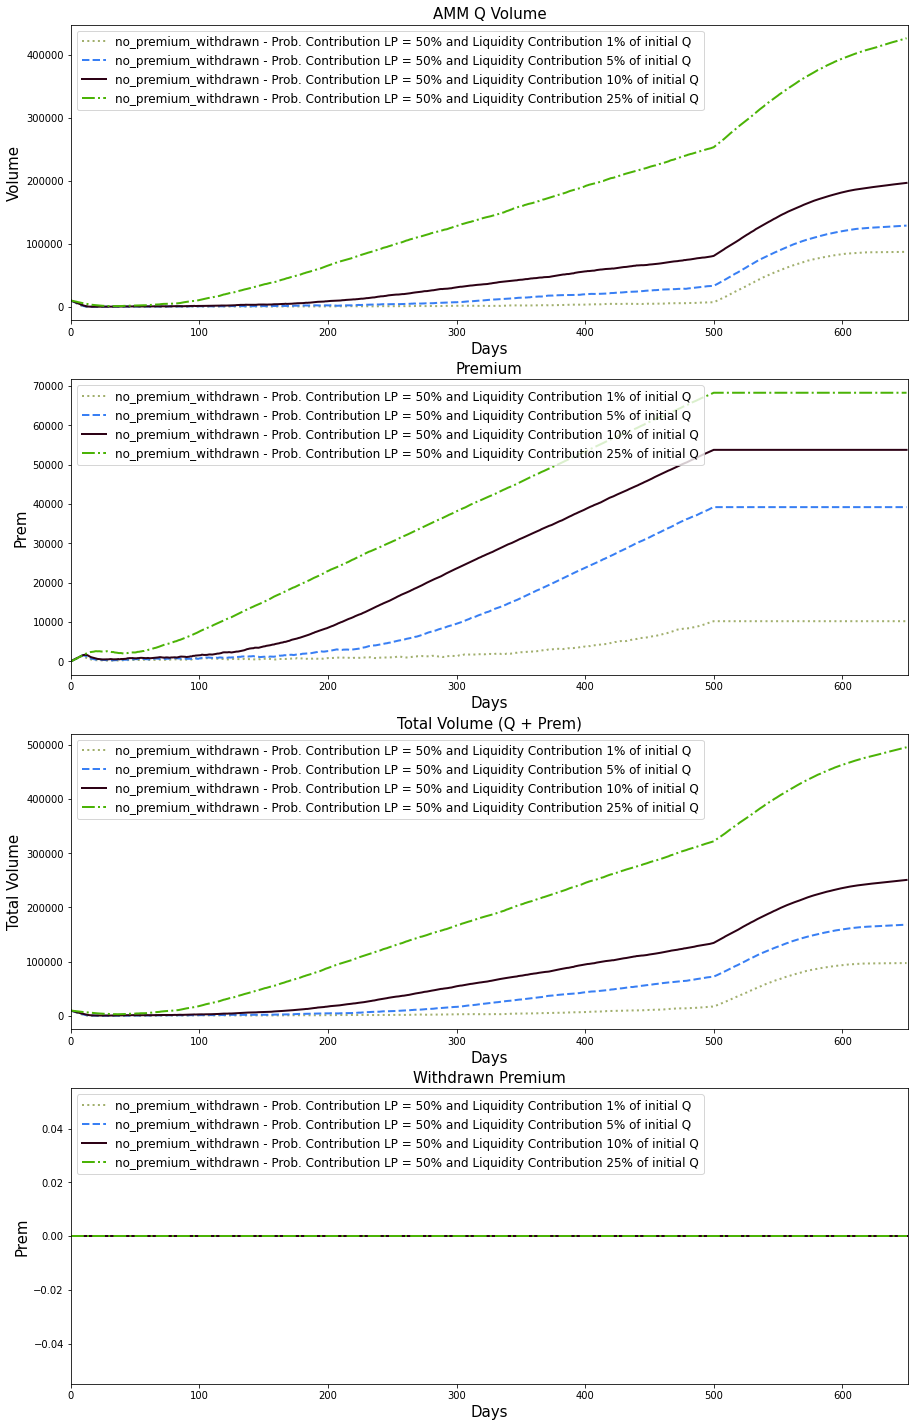

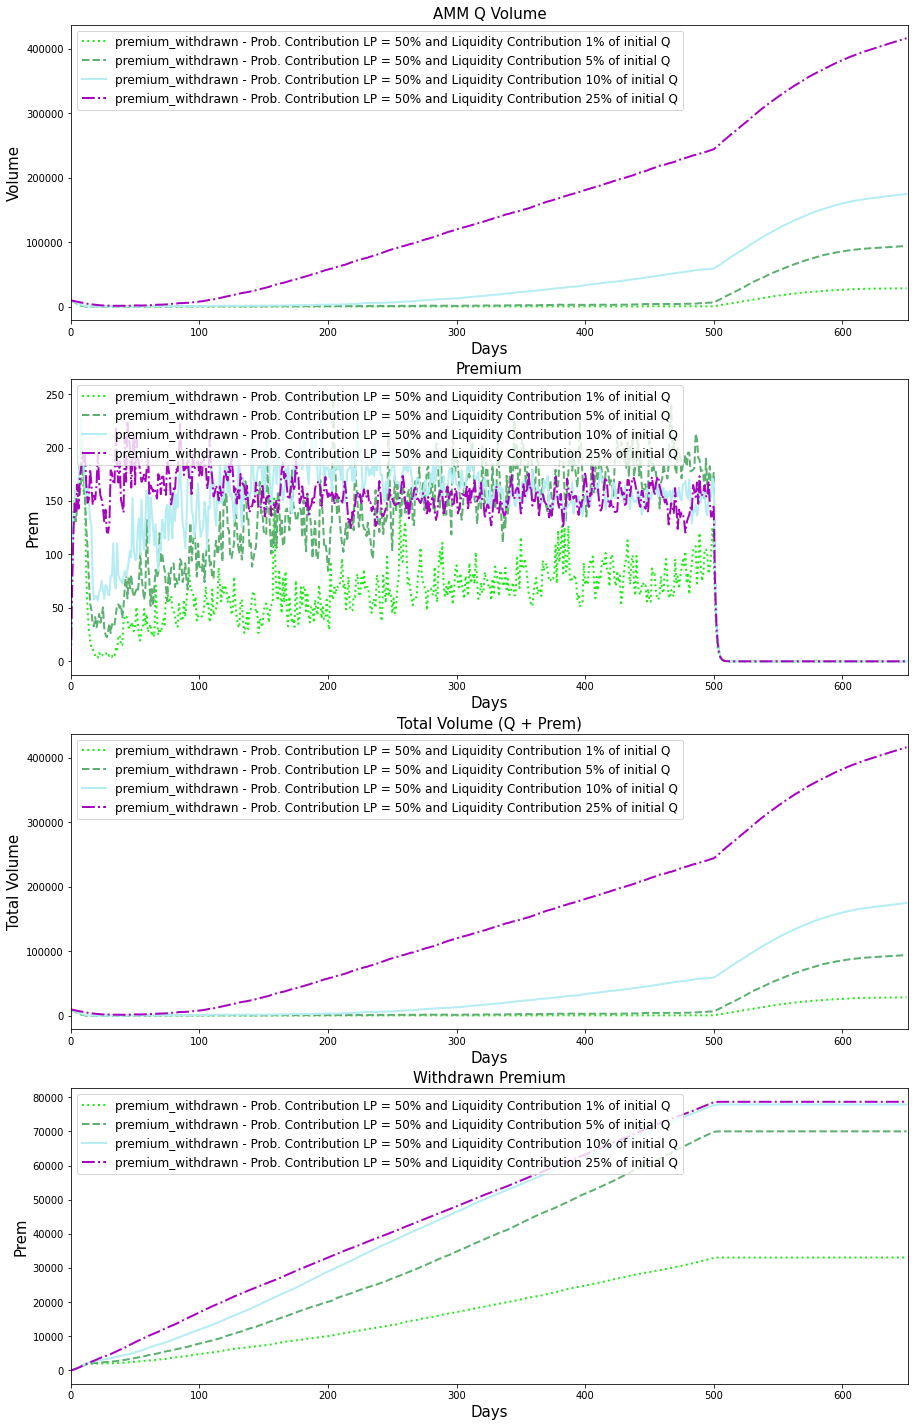

In [11]:
def aux_scenario1(list_values):

    cases_array = {}

    for index, i in enumerate(list_values):
        scenario_1(i[0], i[1])

        cases_array[index] = result()

    for j, sim_name in enumerate(sim_type):
        
        ax, ax2, ax3, ax4, y = aux_plot()

        for index, i in enumerate(list_values):

            arrays_values = cases_array[index]

            q_volume_values = arrays_values[0]
            prem_values = arrays_values[1]
            volume_values = arrays_values[2]
            accu_prem_values = arrays_values[3]

            curve_color = (random.uniform(0,1), random.uniform(0,1), random.uniform(0,1))
            linestyles = ['dotted', 'dashed', 'solid', 'dashdot', (0, (1,10)), (0, (3,5,1,5,1,5))]

            label_value = f"{sim_name} - Prob. Contribution LP = {int(i[0]*100)}% and Liquidity Contribution {int(i[1]*100)}% of initial Q"

            ax.plot(y, q_volume_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=curve_color, label = label_value)
            ax.legend(loc="upper left", prop = {'size': 12})
            ax.grid()

            ax2.plot(y, prem_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=curve_color, label = label_value)
            ax2.legend(loc="upper left", prop = {'size': 12})
            ax2.grid()

            ax3.plot(y, volume_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=curve_color, label = label_value)
            ax3.legend(loc="upper left", prop = {'size': 12})
            ax3.grid()

            ax4.plot(y, accu_prem_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=curve_color, label = label_value)
            ax4.legend(loc="upper left", prop = {'size': 12})
            ax4.grid()

        plt.show()

aux_scenario1(values_scenario1)
reset()

### Scenario 2 simulation

Scenario 2: More and more Unpaid Invoices. 2.0 % of unpaid invoices


Description No Premium Withdrawn  \
0                               Number of simulations                100.0   
1                       Simulation time period (days)                650.0   
2                                   Total of invoices                500.0   
3       Average of accepted invoices (collateralized)               275.77   
4             % of accepted invoices (collateralized)                55.15   
5         Average of paid invoices (capital returned)               270.86   
6               % of paid invoices (capital returned)                98.22   
7   Average of unpaid invoices (capital not returned)                 4.91   
8         % of unpaid invoices (capital not returned)                 1.78   
9                 Average loss due to unpaid invoices             4,135.28   
10                           Total collateral covered           237,591.21   
11                  Total collateral covered x (i.c.)                23.76   
12                            Total premium withdrawn                  0.0   
13                   Total premium withdrawn x (i.c.)                  0.0   
14                              Remaining AMM premium             2,901.97   
15                     Remaining AMM premium x (i.c.)                 0.29   
16                                   Final AMM volume            64,379.69   
17                                         AMM profit            54,379.69   
18                              AMM profit percentage                543.8   

   Premium Withdrawn Premium vs. No Premium Withdrawn  
0              100.0                             0.0%  
1              650.0                             0.0%  
2              500.0                             0.0%  
3             113.61                           -58.8%  
4              22.72                           -58.8%  
5             111.12                          -58.98%  
6              97.81                           -0.42%  
7               2.49                          -49.29%  
8               2.19                           23.03%  
9           1,591.83                          -61.51%  
10         69,318.91                          -70.82%  
11              6.93                          -70.83%  
12         18,897.08                           100.0%  
13              1.89                           100.0%  
14               0.0                          -100.0%  
15               0.0                          -100.0%  
16          9,960.26                          -84.53%  
17         18,857.34                          -65.32%  
18            188.57                          -65.32%

Scenario 2: More and more Unpaid Invoices. 5.0 % of unpaid invoices


Description No Premium Withdrawn  \
0                               Number of simulations                100.0   
1                       Simulation time period (days)                650.0   
2                                   Total of invoices                500.0   
3       Average of accepted invoices (collateralized)                257.8   
4             % of accepted invoices (collateralized)                51.56   
5         Average of paid invoices (capital returned)               245.46   
6               % of paid invoices (capital returned)                95.21   
7   Average of unpaid invoices (capital not returned)                12.34   
8         % of unpaid invoices (capital not returned)                 4.79   
9                 Average loss due to unpaid invoices            10,238.38   
10                           Total collateral covered           215,177.21   
11                  Total collateral covered x (i.c.)                21.52   
12                            Total premium withdrawn                  0.0   
13                   Total premium withdrawn x (i.c.)                  0.0   
14                              Remaining AMM premium             1,654.81   
15                     Remaining AMM premium x (i.c.)                 0.17   
16                                   Final AMM volume            54,232.86   
17                                         AMM profit            44,232.86   
18                              AMM profit percentage               442.33   

   Premium Withdrawn Premium vs. No Premium Withdrawn  
0              100.0                             0.0%  
1              650.0                             0.0%  
2              500.0                             0.0%  
3             107.72                          -58.22%  
4              21.54                          -58.22%  
5             102.28                          -58.33%  
6              94.95                           -0.27%  
7               5.44                          -55.92%  
8               5.05                            5.43%  
9            3,228.8                          -68.46%  
10         63,576.28                          -70.45%  
11              6.36                          -70.45%  
12         17,321.75                           100.0%  
13              1.73                           100.0%  
14               0.0                          -100.0%  
15               0.0                          -100.0%  
16          8,252.41                          -84.78%  
17         15,574.16                          -64.79%  
18            155.74                          -64.79%

Scenario 2: More and more Unpaid Invoices. 20.0 % of unpaid invoices


Description No Premium Withdrawn  \
0                               Number of simulations                100.0   
1                       Simulation time period (days)                650.0   
2                                   Total of invoices                500.0   
3       Average of accepted invoices (collateralized)                178.9   
4             % of accepted invoices (collateralized)                35.78   
5         Average of paid invoices (capital returned)               143.47   
6               % of paid invoices (capital returned)                 80.2   
7   Average of unpaid invoices (capital not returned)                35.43   
8         % of unpaid invoices (capital not returned)                 19.8   
9                 Average loss due to unpaid invoices            25,334.09   
10                           Total collateral covered           126,657.75   
11                  Total collateral covered x (i.c.)                12.67   
12                            Total premium withdrawn                  0.0   
13                   Total premium withdrawn x (i.c.)                  0.0   
14                              Remaining AMM premium                555.9   
15                     Remaining AMM premium x (i.c.)                 0.06   
16                                   Final AMM volume            19,971.35   
17                                         AMM profit             9,971.35   
18                              AMM profit percentage                99.71   

   Premium Withdrawn Premium vs. No Premium Withdrawn  
0              100.0                             0.0%  
1              650.0                             0.0%  
2              500.0                             0.0%  
3              75.48                          -57.81%  
4               15.1                           -57.8%  
5              60.38                          -57.91%  
6              79.99                           -0.26%  
7               15.1                          -57.38%  
8              20.01                            1.06%  
9           8,315.26                          -67.18%  
10         41,722.12                          -67.06%  
11              4.17                          -67.09%  
12         11,746.46                           100.0%  
13              1.17                           100.0%  
14               0.0                          -100.0%  
15               0.0                          -100.0%  
16          2,687.31                          -86.54%  
17          4,433.77                          -55.53%  
18             44.34                          -55.53%

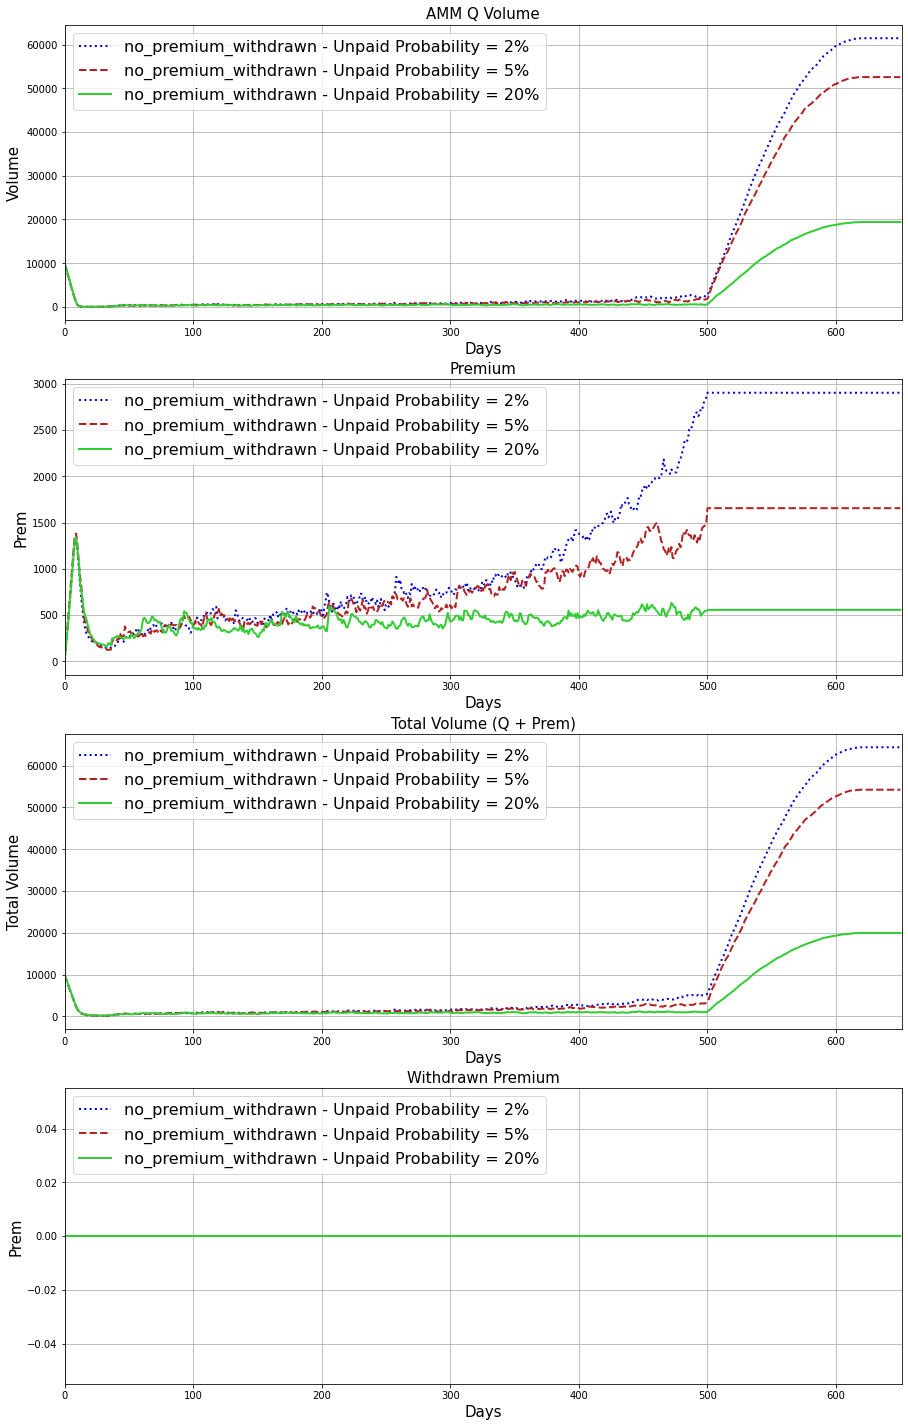

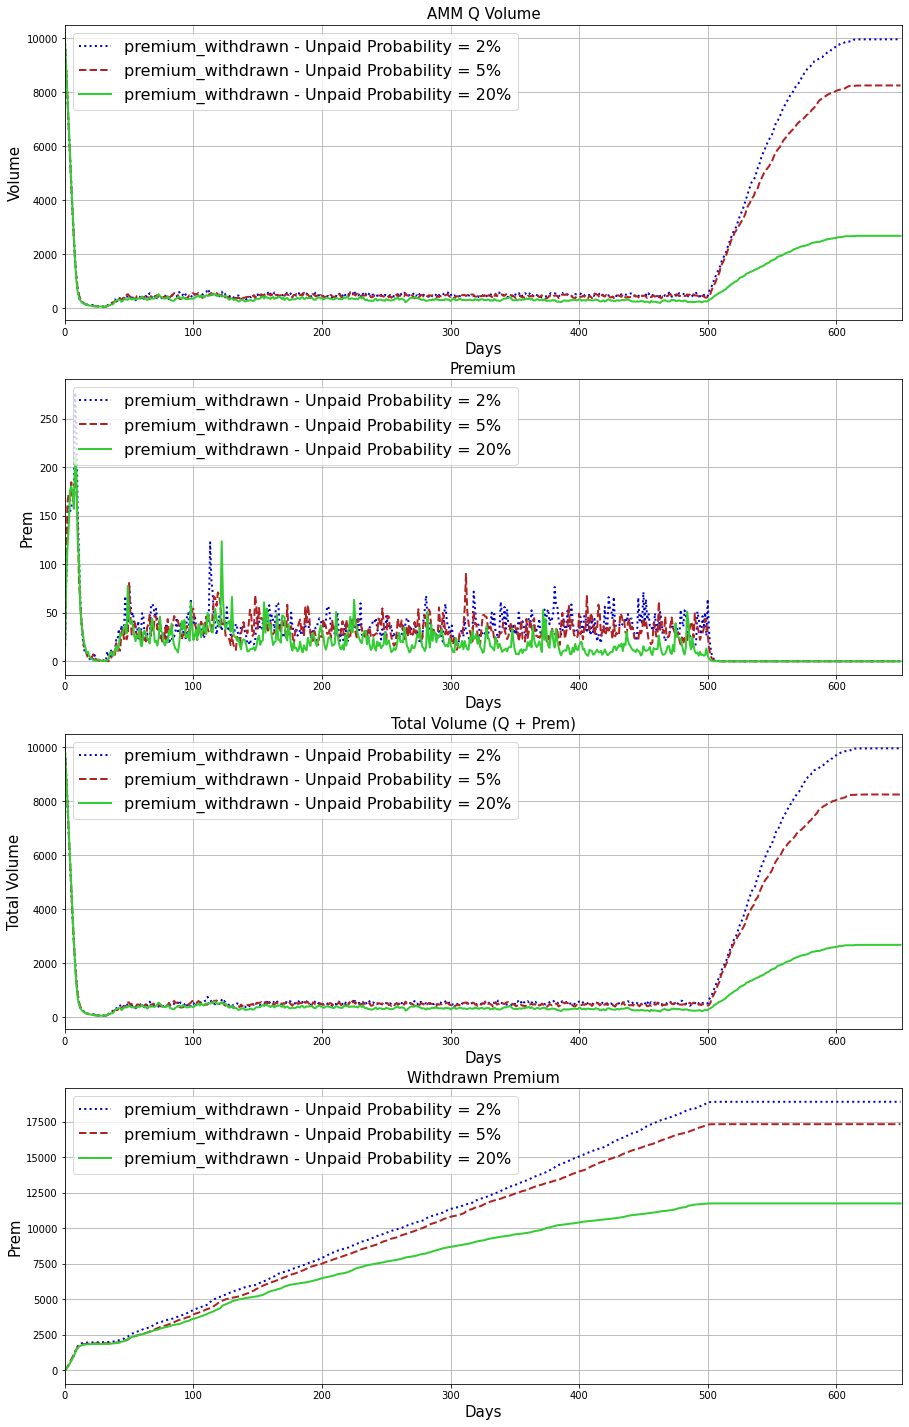

In [12]:
def aux_scenario2(list_values):
    
    cases_array = {}

    for index, i in enumerate(list_values):
        scenario_2(i)

        cases_array[index] = result()

    for j, sim_name in enumerate(sim_type):
        
        ax, ax2, ax3, ax4, y = aux_plot()

        for index, i in enumerate(list_values):

            arrays_values = cases_array[index]

            q_volume_values = arrays_values[0]
            prem_values = arrays_values[1]
            volume_values = arrays_values[2]
            accu_prem_values = arrays_values[3]

            colors = ['mediumblue', 'firebrick', 'limegreen']
            linestyles = ['dotted', 'dashed', 'solid']

            label_value = f"{sim_name} - Unpaid Probability = {int(i*100)}%"

            ax.plot(y, q_volume_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax.legend(loc="upper left", prop = {'size': 16})
            ax.grid()

            ax2.plot(y, prem_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax2.legend(loc="upper left", prop = {'size': 16})
            ax2.grid()

            ax3.plot(y, volume_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax3.legend(loc="upper left", prop = {'size': 16})
            ax3.grid()

            ax4.plot(y, accu_prem_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax4.legend(loc="upper left", prop = {'size': 16})
            ax4.grid()

        plt.show()

aux_scenario2(values_scenario2)
reset()

### Scenario 3 simulation

Scenario 3: More and more Delay in the Invoice Payments. Min delay: 30 days, Max delay: 60 days


Description No Premium Withdrawn  \
0                               Number of simulations                100.0   
1                       Simulation time period (days)                650.0   
2                                   Total of invoices                500.0   
3       Average of accepted invoices (collateralized)               407.04   
4             % of accepted invoices (collateralized)                81.41   
5         Average of paid invoices (capital returned)               407.04   
6               % of paid invoices (capital returned)                100.0   
7   Average of unpaid invoices (capital not returned)                  0.0   
8         % of unpaid invoices (capital not returned)                  0.0   
9                 Average loss due to unpaid invoices                  0.0   
10                           Total collateral covered           405,826.22   
11                  Total collateral covered x (i.c.)                40.58   
12                            Total premium withdrawn                  0.0   
13                   Total premium withdrawn x (i.c.)                  0.0   
14                              Remaining AMM premium            29,743.22   
15                     Remaining AMM premium x (i.c.)                 2.97   
16                                   Final AMM volume            86,573.46   
17                                         AMM profit            76,573.46   
18                              AMM profit percentage               765.73   

   Premium Withdrawn Premium vs. No Premium Withdrawn  
0              100.0                             0.0%  
1              650.0                             0.0%  
2              500.0                             0.0%  
3             174.15                          -57.22%  
4              34.83                          -57.22%  
5             174.15                          -57.22%  
6              100.0                             0.0%  
7                0.0                             0.0%  
8                0.0                             0.0%  
9                0.0                             0.0%  
10        123,098.97                          -69.67%  
11             12.31                          -69.66%  
12         32,408.04                           100.0%  
13              3.24                           100.0%  
14               0.0                          -100.0%  
15               0.0                          -100.0%  
16         12,877.22                          -85.13%  
17         35,285.26                          -53.92%  
18            352.85                          -53.92%

Scenario 3: More and more Delay in the Invoice Payments. Min delay: 60 days, Max delay: 90 days


Description No Premium Withdrawn  \
0                               Number of simulations                100.0   
1                       Simulation time period (days)                650.0   
2                                   Total of invoices                500.0   
3       Average of accepted invoices (collateralized)               263.17   
4             % of accepted invoices (collateralized)                52.63   
5         Average of paid invoices (capital returned)               263.17   
6               % of paid invoices (capital returned)                100.0   
7   Average of unpaid invoices (capital not returned)                  0.0   
8         % of unpaid invoices (capital not returned)                  0.0   
9                 Average loss due to unpaid invoices                  0.0   
10                           Total collateral covered           233,410.43   
11                  Total collateral covered x (i.c.)                23.34   
12                            Total premium withdrawn                  0.0   
13                   Total premium withdrawn x (i.c.)                  0.0   
14                              Remaining AMM premium             2,669.39   
15                     Remaining AMM premium x (i.c.)                 0.27   
16                                   Final AMM volume            66,004.46   
17                                         AMM profit            56,004.46   
18                              AMM profit percentage               560.04   

   Premium Withdrawn Premium vs. No Premium Withdrawn  
0              100.0                             0.0%  
1              650.0                             0.0%  
2              500.0                             0.0%  
3             115.47                          -56.12%  
4              23.09                          -56.13%  
5             115.47                          -56.12%  
6              100.0                             0.0%  
7                0.0                             0.0%  
8                0.0                             0.0%  
9                0.0                             0.0%  
10         74,483.69                          -68.09%  
11              7.45                          -68.08%  
12         19,542.21                           100.0%  
13              1.95                           100.0%  
14               0.0                          -100.0%  
15               0.0                          -100.0%  
16         11,693.24                          -82.28%  
17         21,235.45                          -62.08%  
18            212.35                          -62.08%

Scenario 3: More and more Delay in the Invoice Payments. Min delay: 90 days, Max delay: 120 days


Description No Premium Withdrawn  \
0                               Number of simulations                100.0   
1                       Simulation time period (days)                650.0   
2                                   Total of invoices                500.0   
3       Average of accepted invoices (collateralized)               161.09   
4             % of accepted invoices (collateralized)                32.22   
5         Average of paid invoices (capital returned)               161.09   
6               % of paid invoices (capital returned)                100.0   
7   Average of unpaid invoices (capital not returned)                  0.0   
8         % of unpaid invoices (capital not returned)                  0.0   
9                 Average loss due to unpaid invoices                  0.0   
10                           Total collateral covered           128,565.98   
11                  Total collateral covered x (i.c.)                12.86   
12                            Total premium withdrawn                  0.0   
13                   Total premium withdrawn x (i.c.)                  0.0   
14                              Remaining AMM premium               226.09   
15                     Remaining AMM premium x (i.c.)                 0.02   
16                                   Final AMM volume            43,732.93   
17                                         AMM profit            33,732.93   
18                              AMM profit percentage               337.33   

   Premium Withdrawn Premium vs. No Premium Withdrawn  
0              100.0                             0.0%  
1              650.0                             0.0%  
2              500.0                             0.0%  
3               78.8                          -51.08%  
4              15.76                          -51.09%  
5               78.8                          -51.08%  
6              100.0                             0.0%  
7                0.0                             0.0%  
8                0.0                             0.0%  
9                0.0                             0.0%  
10          52,039.5                          -59.52%  
11               5.2                          -59.56%  
12         13,152.92                           100.0%  
13              1.32                           100.0%  
14               0.0                          -100.0%  
15               0.0                          -100.0%  
16         10,951.18                          -74.96%  
17          14,104.1                          -58.19%  
18            141.04                          -58.19%

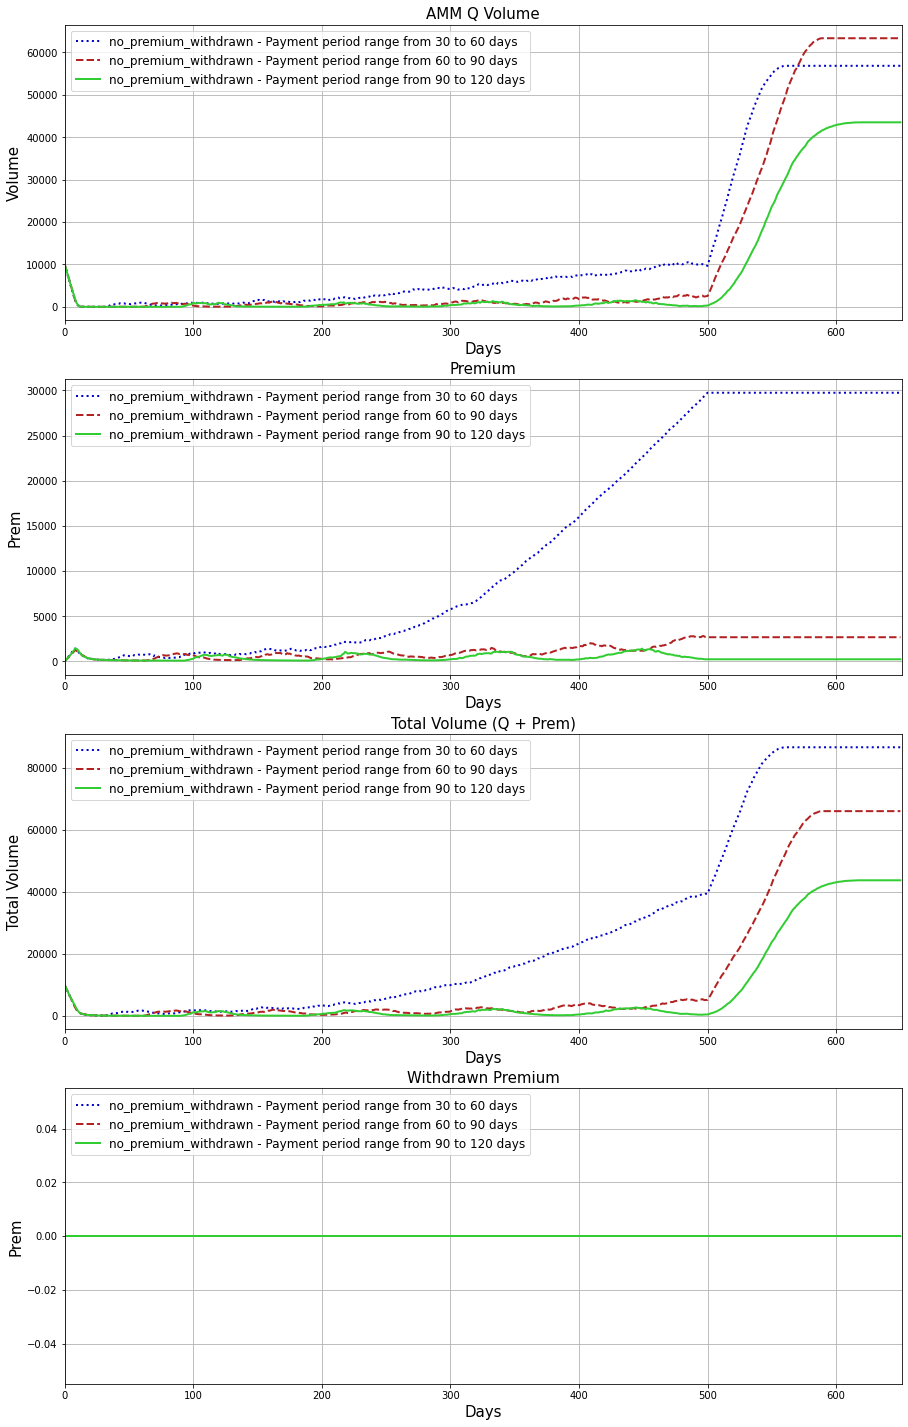

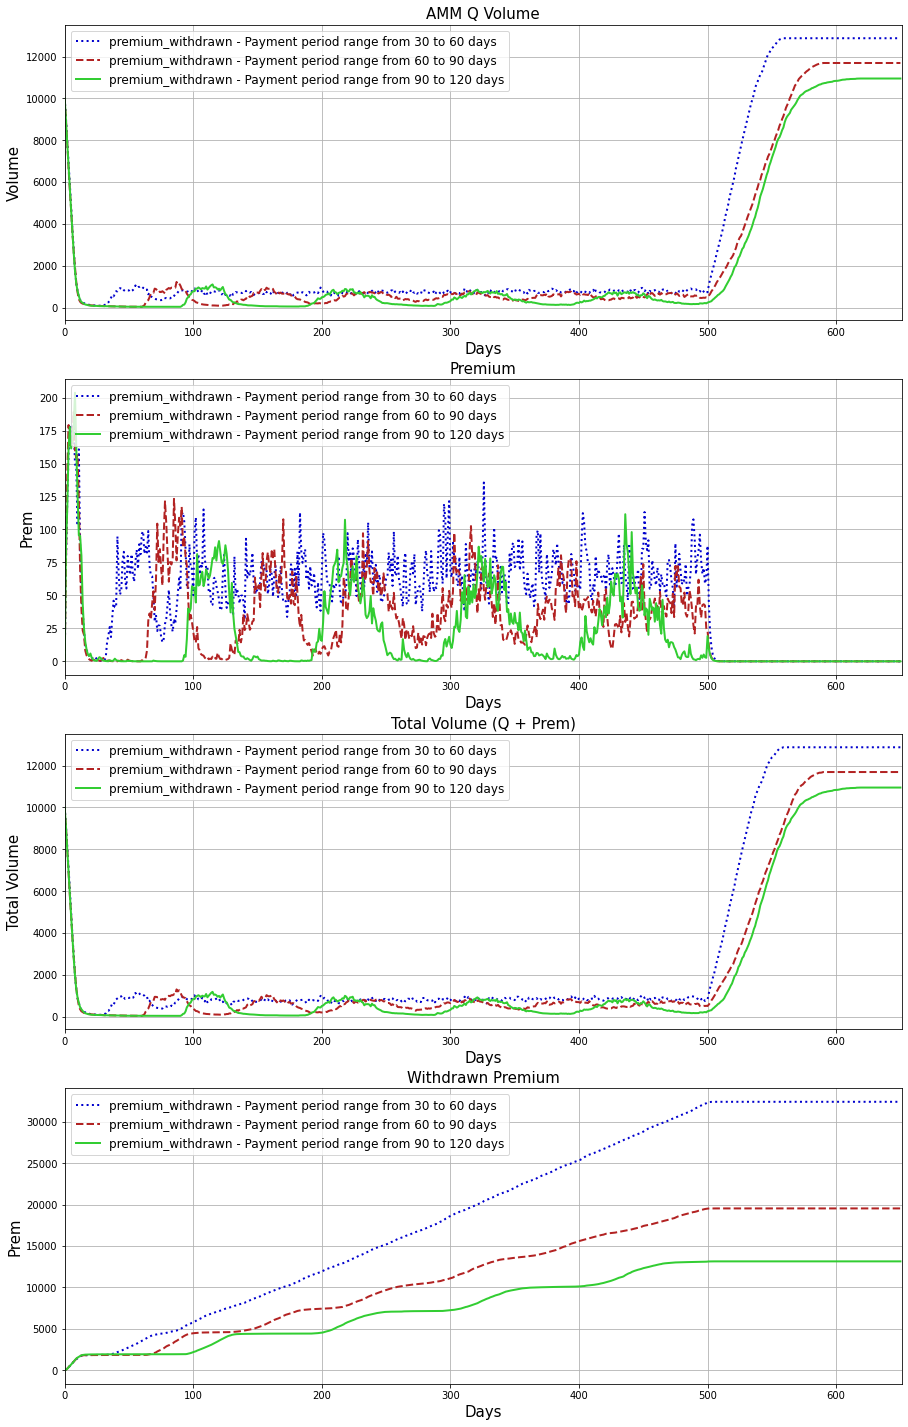

In [13]:
def aux_scenario3(list_values):

    cases_array = {}

    for index, i in enumerate(list_values):
        scenario_3(i[0], i[1])

        cases_array[index] = result()

    for j, sim_name in enumerate(sim_type):
        
        ax, ax2, ax3, ax4, y = aux_plot()

        for index, i in enumerate(list_values):

            arrays_values = cases_array[index]

            q_volume_values = arrays_values[0]
            prem_values = arrays_values[1]
            volume_values = arrays_values[2]
            accu_prem_values = arrays_values[3]

            colors = ['mediumblue', 'firebrick', 'limegreen']
            linestyles = ['dotted', 'dashed', 'solid']

            label_value = f"{sim_name} - Payment period range from {int(i[0])} to {int(i[1])} days"

            ax.plot(y, q_volume_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax.legend(loc="upper left", prop = {'size': 12})
            ax.grid()

            ax2.plot(y, prem_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax2.legend(loc="upper left", prop = {'size': 12})
            ax2.grid()

            ax3.plot(y, volume_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax3.legend(loc="upper left", prop = {'size': 12})
            ax3.grid()

            ax4.plot(y, accu_prem_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax4.legend(loc="upper left", prop = {'size': 12})
            ax4.grid()

        plt.show()

aux_scenario3(values_scenario3)
reset()

### Scenario 4 simulation

Scenario 4: Playing with Growing Invoices, therefore growing demanded collateral. Demanded collateral: 1.0 % of initial Q


Description No Premium Withdrawn  \
0                               Number of simulations                100.0   
1                       Simulation time period (days)                650.0   
2                                   Total of invoices                500.0   
3       Average of accepted invoices (collateralized)                500.0   
4             % of accepted invoices (collateralized)                100.0   
5         Average of paid invoices (capital returned)                500.0   
6               % of paid invoices (capital returned)                100.0   
7   Average of unpaid invoices (capital not returned)                  0.0   
8         % of unpaid invoices (capital not returned)                  0.0   
9                 Average loss due to unpaid invoices                  0.0   
10                           Total collateral covered             50,000.0   
11                  Total collateral covered x (i.c.)                  5.0   
12                            Total premium withdrawn                  0.0   
13                   Total premium withdrawn x (i.c.)                  0.0   
14                              Remaining AMM premium             7,269.12   
15                     Remaining AMM premium x (i.c.)                 0.73   
16                                   Final AMM volume            17,269.12   
17                                         AMM profit             7,269.12   
18                              AMM profit percentage                72.69   

   Premium Withdrawn Premium vs. No Premium Withdrawn  
0              100.0                             0.0%  
1              650.0                             0.0%  
2              500.0                             0.0%  
3              500.0                             0.0%  
4              100.0                             0.0%  
5              500.0                             0.0%  
6              100.0                             0.0%  
7                0.0                             0.0%  
8                0.0                             0.0%  
9                0.0                             0.0%  
10          50,000.0                             0.0%  
11               5.0                             0.0%  
12          7,358.48                           100.0%  
13              0.74                           100.0%  
14               0.0                          -100.0%  
15               0.0                          -100.0%  
16          10,000.0                          -42.09%  
17          7,358.48                            1.23%  
18             73.58                            1.22%

Scenario 4: Playing with Growing Invoices, therefore growing demanded collateral. Demanded collateral: 10.0 % of initial Q


Description No Premium Withdrawn  \
0                               Number of simulations                100.0   
1                       Simulation time period (days)                650.0   
2                                   Total of invoices                500.0   
3       Average of accepted invoices (collateralized)               242.22   
4             % of accepted invoices (collateralized)                48.44   
5         Average of paid invoices (capital returned)               242.22   
6               % of paid invoices (capital returned)                100.0   
7   Average of unpaid invoices (capital not returned)                  0.0   
8         % of unpaid invoices (capital not returned)                  0.0   
9                 Average loss due to unpaid invoices                  0.0   
10                           Total collateral covered            242,220.0   
11                  Total collateral covered x (i.c.)                24.22   
12                            Total premium withdrawn                  0.0   
13                   Total premium withdrawn x (i.c.)                  0.0   
14                              Remaining AMM premium             2,831.88   
15                     Remaining AMM premium x (i.c.)                 0.28   
16                                   Final AMM volume            67,011.88   
17                                         AMM profit            57,011.88   
18                              AMM profit percentage               570.12   

   Premium Withdrawn Premium vs. No Premium Withdrawn  
0              100.0                             0.0%  
1              650.0                             0.0%  
2              500.0                             0.0%  
3               89.0                          -63.26%  
4               17.8                          -63.25%  
5               89.0                          -63.26%  
6              100.0                             0.0%  
7                0.0                             0.0%  
8                0.0                             0.0%  
9                0.0                             0.0%  
10          89,000.0                          -63.26%  
11               8.9                          -63.25%  
12         39,026.92                           100.0%  
13               3.9                           100.0%  
14               0.0                          -100.0%  
15               0.0                          -100.0%  
16          15,270.0                          -77.21%  
17         44,296.92                           -22.3%  
18            442.97                           -22.3%

Scenario 4: Playing with Growing Invoices, therefore growing demanded collateral. Demanded collateral: 25.0 % of initial Q


Description No Premium Withdrawn  \
0                               Number of simulations                100.0   
1                       Simulation time period (days)                650.0   
2                                   Total of invoices                500.0   
3       Average of accepted invoices (collateralized)               114.34   
4             % of accepted invoices (collateralized)                22.87   
5         Average of paid invoices (capital returned)               114.34   
6               % of paid invoices (capital returned)                100.0   
7   Average of unpaid invoices (capital not returned)                  0.0   
8         % of unpaid invoices (capital not returned)                  0.0   
9                 Average loss due to unpaid invoices                  0.0   
10                           Total collateral covered            285,850.0   
11                  Total collateral covered x (i.c.)                28.59   
12                            Total premium withdrawn                  0.0   
13                   Total premium withdrawn x (i.c.)                  0.0   
14                              Remaining AMM premium             2,414.29   
15                     Remaining AMM premium x (i.c.)                 0.24   
16                                   Final AMM volume            86,639.29   
17                                         AMM profit            76,639.29   
18                              AMM profit percentage               766.39   

   Premium Withdrawn Premium vs. No Premium Withdrawn  
0              100.0                             0.0%  
1              650.0                             0.0%  
2              500.0                             0.0%  
3              41.11                          -64.05%  
4               8.22                          -64.06%  
5              41.11                          -64.05%  
6              100.0                             0.0%  
7                0.0                             0.0%  
8                0.0                             0.0%  
9                0.0                             0.0%  
10         102,775.0                          -64.05%  
11             10.28                          -64.04%  
12         51,433.45                           100.0%  
13              5.14                           100.0%  
14               0.0                          -100.0%  
15               0.0                          -100.0%  
16          18,750.0                          -78.36%  
17         60,183.45                          -21.47%  
18            601.83                          -21.47%

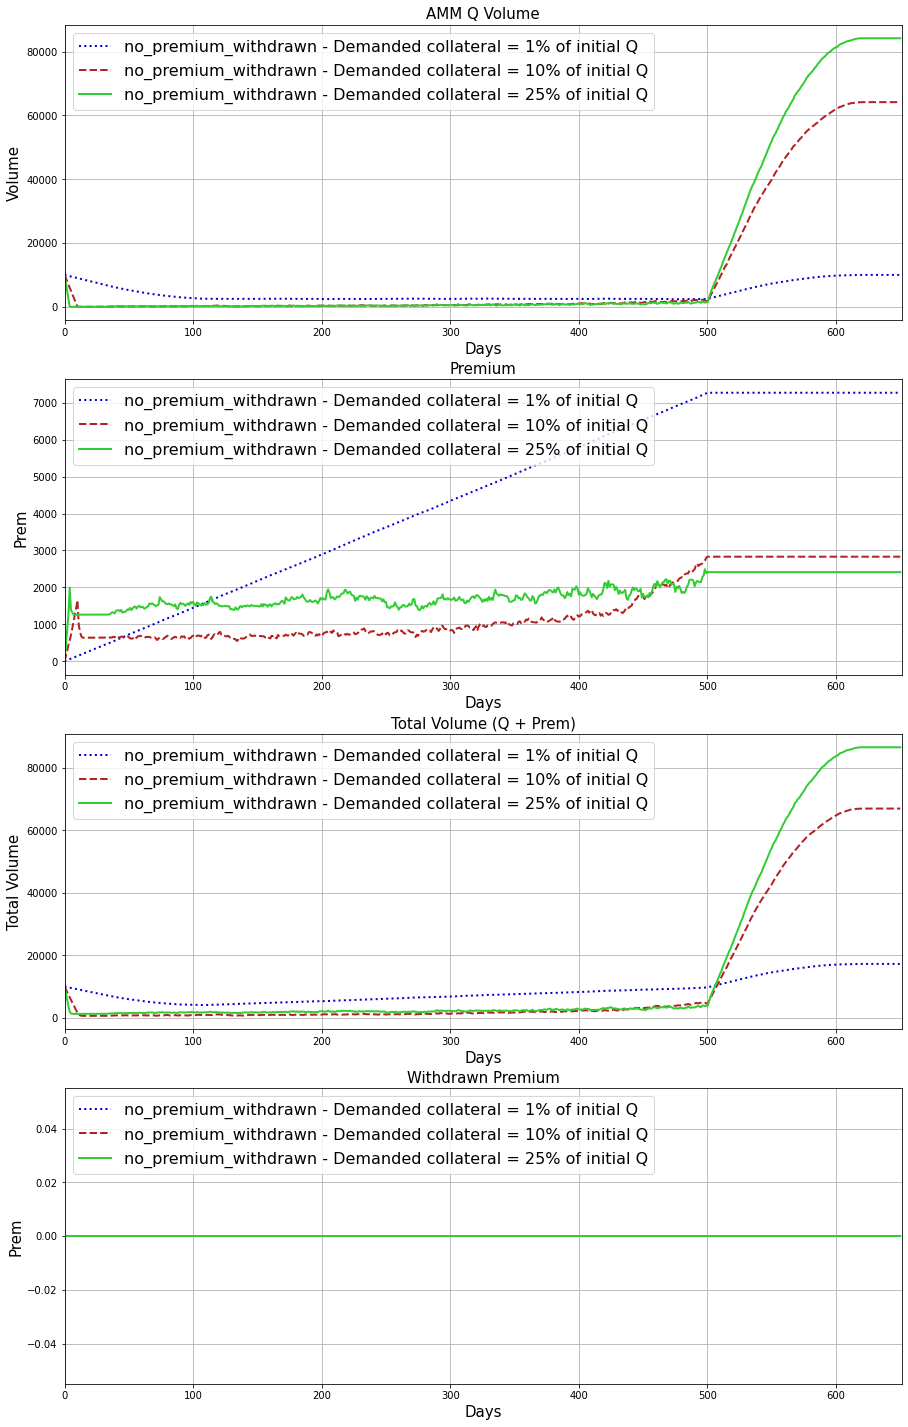

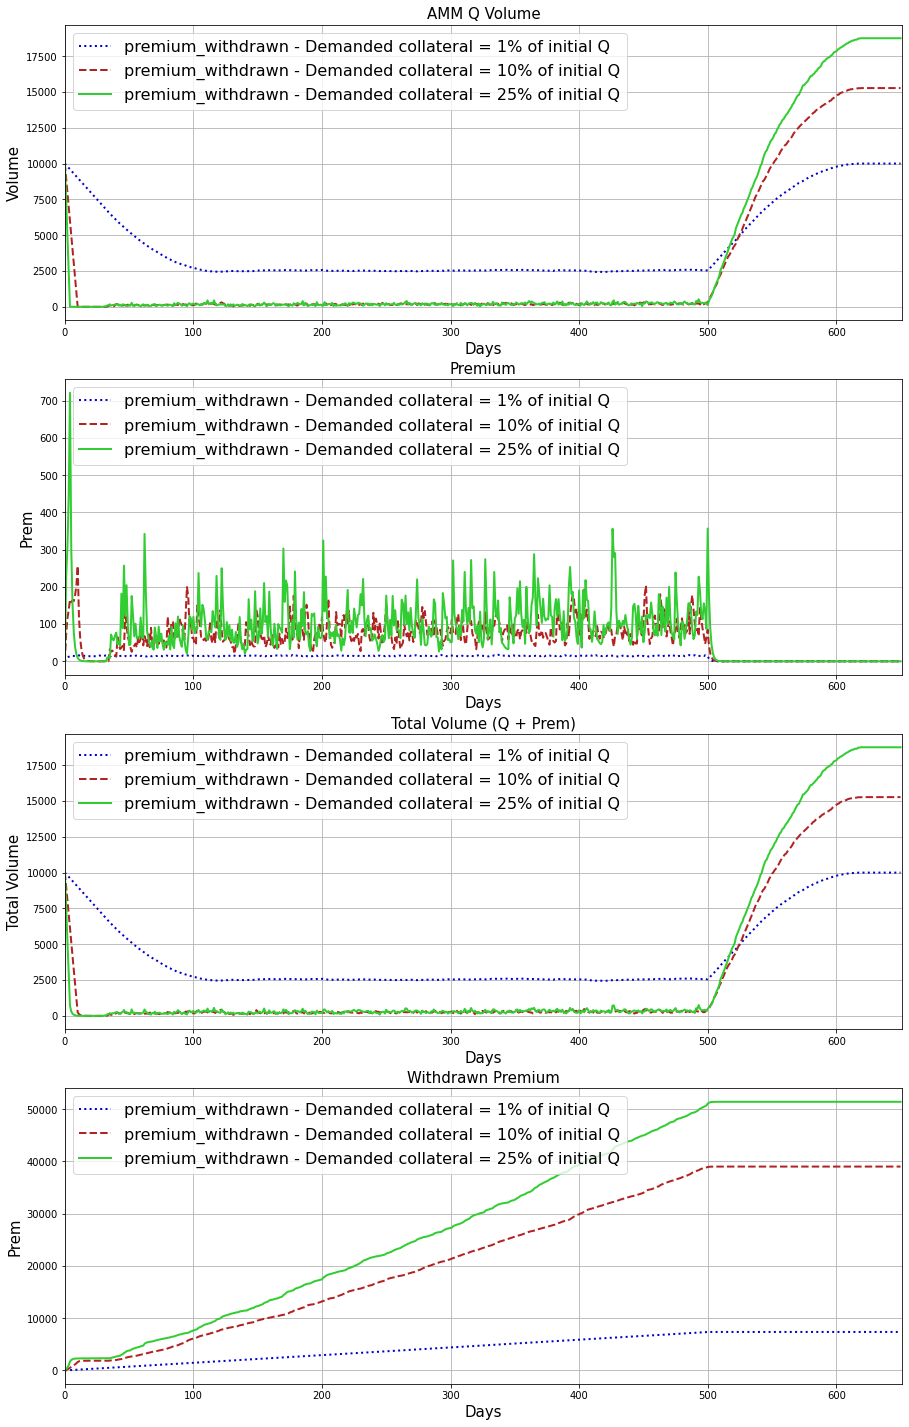

In [14]:
def aux_scenario4(list_values):

    cases_array = {}

    for index, i in enumerate(list_values):
        scenario_4(i)

        cases_array[index] = result()

    for j, sim_name in enumerate(sim_type):
        
        ax, ax2, ax3, ax4, y = aux_plot()

        for index, i in enumerate(list_values):

            arrays_values = cases_array[index]

            q_volume_values = arrays_values[0]
            prem_values = arrays_values[1]
            volume_values = arrays_values[2]
            accu_prem_values = arrays_values[3]

            colors = ['mediumblue', 'firebrick', 'limegreen']
            linestyles = ['dotted', 'dashed', 'solid']

            label_value = f"{sim_name} - Demanded collateral = {int(i*100)}% of initial Q"

            ax.plot(y, q_volume_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax.legend(loc="upper left", prop = {'size': 16})
            ax.grid()

            ax2.plot(y, prem_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax2.legend(loc="upper left", prop = {'size': 16})
            ax2.grid()

            ax3.plot(y, volume_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax3.legend(loc="upper left", prop = {'size': 16})
            ax3.grid()

            ax4.plot(y, accu_prem_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax4.legend(loc="upper left", prop = {'size': 16})
            ax4.grid()

        plt.show()

aux_scenario4(values_scenario4)
reset()

### Scenario 5 simulation

Scenario 5: Playing with Growing % of Collateral with a Same Invoice amount. 55.0 %  collateralized


Description No Premium Withdrawn  \
0                               Number of simulations                100.0   
1                       Simulation time period (days)                650.0   
2                                   Total of invoices                500.0   
3       Average of accepted invoices (collateralized)               485.56   
4             % of accepted invoices (collateralized)                97.11   
5         Average of paid invoices (capital returned)               485.56   
6               % of paid invoices (capital returned)                100.0   
7   Average of unpaid invoices (capital not returned)                  0.0   
8         % of unpaid invoices (capital not returned)                  0.0   
9                 Average loss due to unpaid invoices                  0.0   
10                           Total collateral covered           502,902.81   
11                  Total collateral covered x (i.c.)                50.29   
12                            Total premium withdrawn                  0.0   
13                   Total premium withdrawn x (i.c.)                  0.0   
14                              Remaining AMM premium           135,737.91   
15                     Remaining AMM premium x (i.c.)                13.57   
16                                   Final AMM volume           228,477.46   
17                                         AMM profit           218,477.46   
18                              AMM profit percentage             2,184.77   

   Premium Withdrawn Premium vs. No Premium Withdrawn  
0              100.0                             0.0%  
1              650.0                             0.0%  
2              500.0                             0.0%  
3             151.16                          -68.87%  
4              30.23                          -68.87%  
5             151.16                          -68.87%  
6              100.0                             0.0%  
7                0.0                             0.0%  
8                0.0                             0.0%  
9                0.0                             0.0%  
10        100,393.39                          -80.04%  
11             10.04                          -80.04%  
12         79,538.51                           100.0%  
13              7.95                           100.0%  
14               0.0                          -100.0%  
15               0.0                          -100.0%  
16         19,351.21                          -91.53%  
17         88,889.72                          -59.31%  
18             888.9                          -59.31%

Scenario 5: Playing with Growing % of Collateral with a Same Invoice amount. 75.0 %  collateralized


Description No Premium Withdrawn  \
0                               Number of simulations                100.0   
1                       Simulation time period (days)                650.0   
2                                   Total of invoices                500.0   
3       Average of accepted invoices (collateralized)               164.01   
4             % of accepted invoices (collateralized)                 32.8   
5         Average of paid invoices (capital returned)               164.01   
6               % of paid invoices (capital returned)                100.0   
7   Average of unpaid invoices (capital not returned)                  0.0   
8         % of unpaid invoices (capital not returned)                  0.0   
9                 Average loss due to unpaid invoices                  0.0   
10                           Total collateral covered           109,351.73   
11                  Total collateral covered x (i.c.)                10.94   
12                            Total premium withdrawn                  0.0   
13                   Total premium withdrawn x (i.c.)                  0.0   
14                              Remaining AMM premium               324.74   
15                     Remaining AMM premium x (i.c.)                 0.03   
16                                   Final AMM volume            21,563.64   
17                                         AMM profit            11,563.64   
18                              AMM profit percentage               115.64   

   Premium Withdrawn Premium vs. No Premium Withdrawn  
0              100.0                             0.0%  
1              650.0                             0.0%  
2              500.0                             0.0%  
3             113.96                          -30.52%  
4              22.79                          -30.52%  
5             113.96                          -30.52%  
6              100.0                             0.0%  
7                0.0                             0.0%  
8                0.0                             0.0%  
9                0.0                             0.0%  
10         68,201.93                          -37.63%  
11              6.82                          -37.66%  
12          7,144.89                           100.0%  
13              0.71                           100.0%  
14               0.0                          -100.0%  
15               0.0                          -100.0%  
16         10,060.89                          -53.34%  
17          7,205.78                          -37.69%  
18             72.06                          -37.69%

Scenario 5: Playing with Growing % of Collateral with a Same Invoice amount. 90.0 %  collateralized


Description No Premium Withdrawn  \
0                               Number of simulations                100.0   
1                       Simulation time period (days)                650.0   
2                                   Total of invoices                500.0   
3       Average of accepted invoices (collateralized)               120.09   
4             % of accepted invoices (collateralized)                24.02   
5         Average of paid invoices (capital returned)               120.09   
6               % of paid invoices (capital returned)                100.0   
7   Average of unpaid invoices (capital not returned)                  0.0   
8         % of unpaid invoices (capital not returned)                  0.0   
9                 Average loss due to unpaid invoices                  0.0   
10                           Total collateral covered            71,872.98   
11                  Total collateral covered x (i.c.)                 7.19   
12                            Total premium withdrawn                  0.0   
13                   Total premium withdrawn x (i.c.)                  0.0   
14                              Remaining AMM premium                72.66   
15                     Remaining AMM premium x (i.c.)                 0.01   
16                                   Final AMM volume            10,857.71   
17                                         AMM profit               857.71   
18                              AMM profit percentage                 8.58   

   Premium Withdrawn Premium vs. No Premium Withdrawn  
0              100.0                             0.0%  
1              650.0                             0.0%  
2              500.0                             0.0%  
3             114.05                           -5.03%  
4              22.81                           -5.04%  
5             114.05                           -5.03%  
6              100.0                             0.0%  
7                0.0                             0.0%  
8                0.0                             0.0%  
9                0.0                             0.0%  
10         67,977.85                           -5.42%  
11               6.8                           -5.42%  
12            810.15                           100.0%  
13              0.08                           100.0%  
14               0.0                          -100.0%  
15               0.0                          -100.0%  
16          10,000.9                           -7.89%  
17            811.05                           -5.44%  
18              8.11                           -5.48%

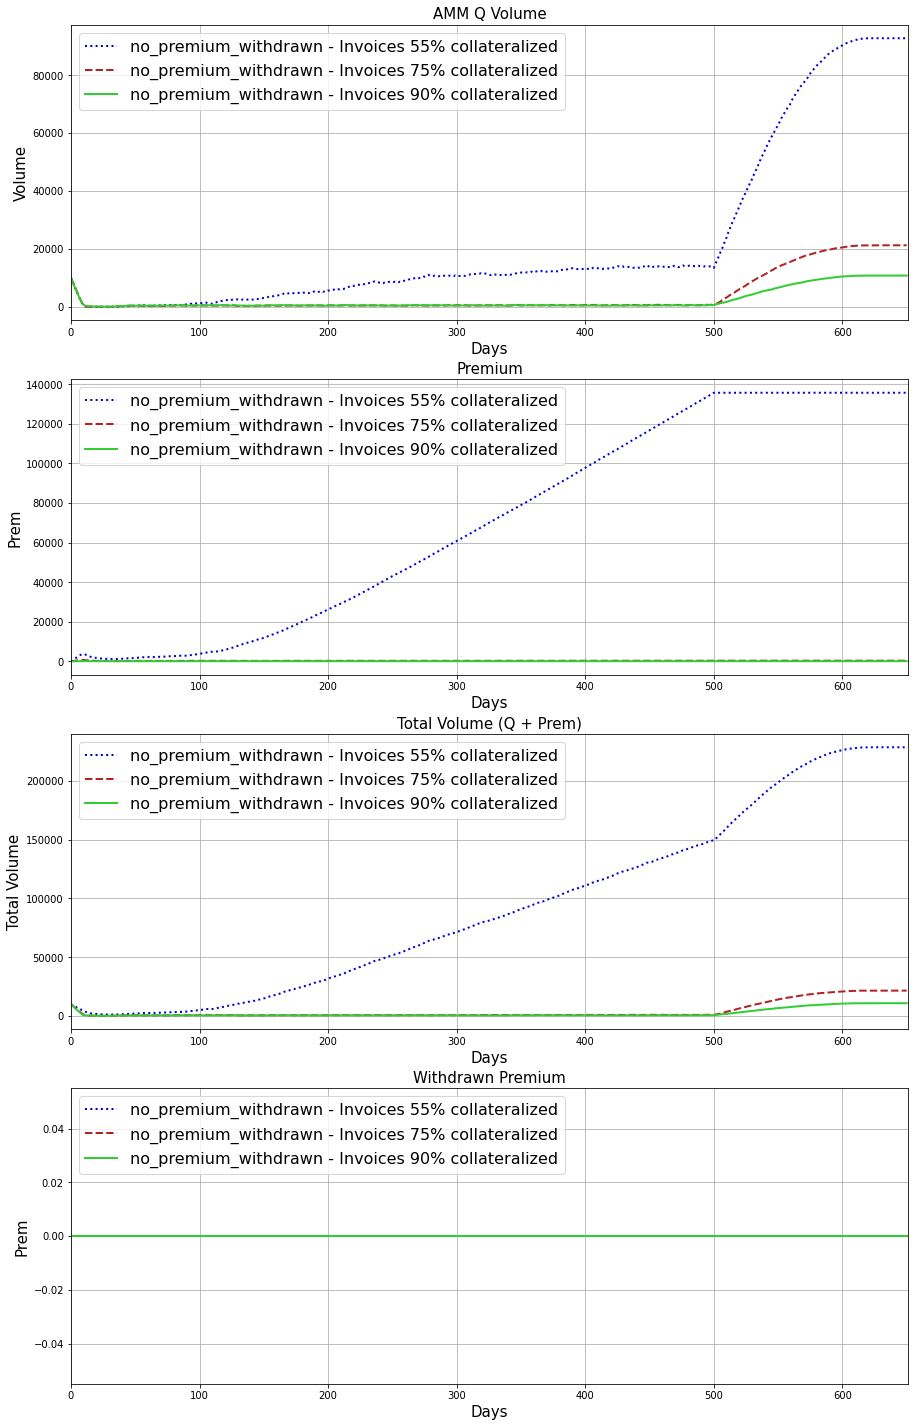

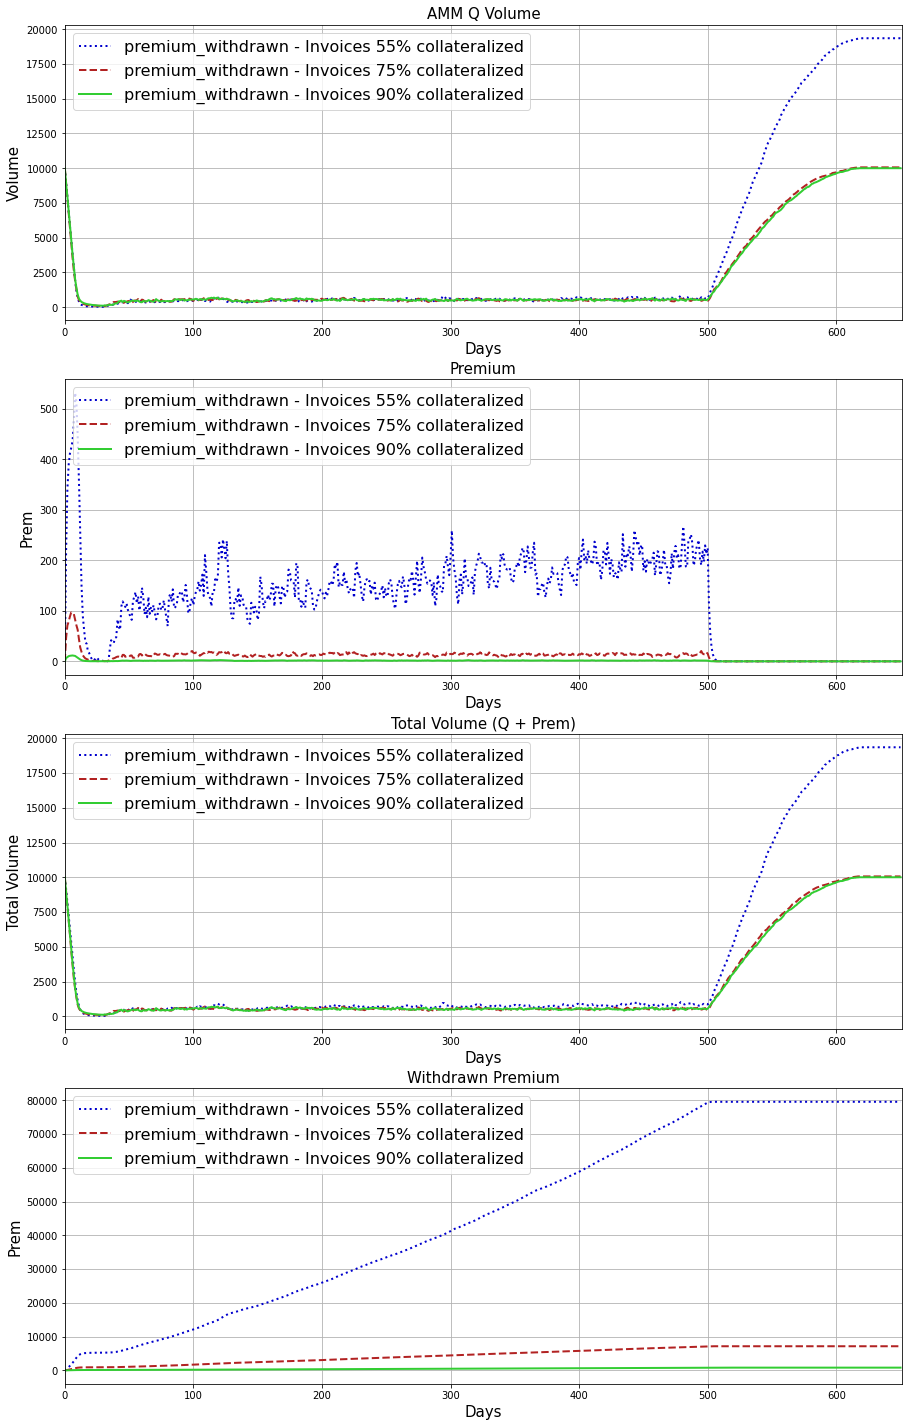

In [15]:
def aux_scenario5(list_values):

    cases_array = {}

    for index, i in enumerate(list_values):
        scenario_5(i)

        cases_array[index] = result()

    for j, sim_name in enumerate(sim_type):
        
        ax, ax2, ax3, ax4, y = aux_plot()

        for index, i in enumerate(list_values):

            arrays_values = cases_array[index]

            q_volume_values = arrays_values[0]
            prem_values = arrays_values[1]
            volume_values = arrays_values[2]
            accu_prem_values = arrays_values[3]

            colors = ['mediumblue', 'firebrick', 'limegreen']
            linestyles = ['dotted', 'dashed', 'solid']

            label_value = f"{sim_name} - Invoices {int(i*100)}% collateralized"

            ax.plot(y, q_volume_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax.legend(loc="upper left", prop = {'size': 16})
            ax.grid()

            ax2.plot(y, prem_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax2.legend(loc="upper left", prop = {'size': 16})
            ax2.grid()

            ax3.plot(y, volume_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax3.legend(loc="upper left", prop = {'size': 16})
            ax3.grid()

            ax4.plot(y, accu_prem_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = label_value)
            ax4.legend(loc="upper left", prop = {'size': 16})
            ax4.grid()

        plt.show()

aux_scenario5(values_scenario5)
reset()

### Hack Scenario simulation

Hack Scenario. Hack prob. 10.0 % with invoices 51.0 % collateralized


Description No Premium Withdrawn  \
0                               Number of simulations                100.0   
1                       Simulation time period (days)                650.0   
2                                   Total of invoices                500.0   
3       Average of accepted invoices (collateralized)               499.79   
4             % of accepted invoices (collateralized)                99.96   
5         Average of paid invoices (capital returned)               450.17   
6               % of paid invoices (capital returned)                90.07   
7   Average of unpaid invoices (capital not returned)                49.62   
8         % of unpaid invoices (capital not returned)                 9.93   
9                 Average loss due to unpaid invoices            52,176.41   
10                           Total collateral covered           526,236.24   
11                  Total collateral covered x (i.c.)                52.62   
12                            Total premium withdrawn                  0.0   
13                   Total premium withdrawn x (i.c.)                  0.0   
14                              Remaining AMM premium            163,213.9   
15                     Remaining AMM premium x (i.c.)                16.32   
16                                   Final AMM volume           240,348.25   
17                                         AMM profit           230,348.25   
18                              AMM profit percentage             2,303.48   

   Premium Withdrawn Premium vs. No Premium Withdrawn  
0              100.0                             0.0%  
1              650.0                             0.0%  
2              500.0                             0.0%  
3             237.51                          -52.48%  
4               47.5                          -52.48%  
5             212.57                          -52.78%  
6               89.5                           -0.63%  
7              24.94                          -49.74%  
8               10.5                            5.74%  
9          20,699.67                          -60.33%  
10        199,060.06                          -62.17%  
11             19.91                          -62.16%  
12        268,258.98                           100.0%  
13             26.83                           100.0%  
14               0.0                          -100.0%  
15               0.0                          -100.0%  
16         42,984.38                          -82.12%  
17        301,243.36                           30.78%  
18          3,012.43                           30.78%

Hack Scenario. Hack prob. 10.0 % with invoices 70.0 % collateralized


Description No Premium Withdrawn  \
0                               Number of simulations                100.0   
1                       Simulation time period (days)                650.0   
2                                   Total of invoices                500.0   
3       Average of accepted invoices (collateralized)               166.58   
4             % of accepted invoices (collateralized)                33.32   
5         Average of paid invoices (capital returned)               149.83   
6               % of paid invoices (capital returned)                89.94   
7   Average of unpaid invoices (capital not returned)                16.75   
8         % of unpaid invoices (capital not returned)                10.06   
9                 Average loss due to unpaid invoices            10,843.19   
10                           Total collateral covered            110,026.8   
11                  Total collateral covered x (i.c.)                 11.0   
12                            Total premium withdrawn                  0.0   
13                   Total premium withdrawn x (i.c.)                  0.0   
14                              Remaining AMM premium               398.89   
15                     Remaining AMM premium x (i.c.)                 0.04   
16                                   Final AMM volume            18,701.97   
17                                         AMM profit             8,701.97   
18                              AMM profit percentage                87.02   

   Premium Withdrawn Premium vs. No Premium Withdrawn  
0              100.0                             0.0%  
1              650.0                             0.0%  
2              500.0                             0.0%  
3              90.13                          -45.89%  
4              18.03                          -45.89%  
5              80.71                          -46.13%  
6              89.55                           -0.43%  
7               9.42                          -43.76%  
8              10.45                            3.88%  
9           5,298.98                          -51.13%  
10         50,760.04                          -53.87%  
11              5.08                          -53.82%  
12          8,848.98                           100.0%  
13              0.88                           100.0%  
14               0.0                          -100.0%  
15               0.0                          -100.0%  
16          4,821.54                          -74.22%  
17          3,670.52                          -57.82%  
18             36.71                          -57.81%

Hack Scenario. Hack prob. 10.0 % with invoices 90.0 % collateralized


Description No Premium Withdrawn  \
0                               Number of simulations                100.0   
1                       Simulation time period (days)                650.0   
2                                   Total of invoices                500.0   
3       Average of accepted invoices (collateralized)                93.44   
4             % of accepted invoices (collateralized)                18.69   
5         Average of paid invoices (capital returned)                83.92   
6               % of paid invoices (capital returned)                89.81   
7   Average of unpaid invoices (capital not returned)                 9.52   
8         % of unpaid invoices (capital not returned)                10.19   
9                 Average loss due to unpaid invoices             5,387.99   
10                           Total collateral covered            51,864.71   
11                  Total collateral covered x (i.c.)                 5.19   
12                            Total premium withdrawn                  0.0   
13                   Total premium withdrawn x (i.c.)                  0.0   
14                              Remaining AMM premium                57.15   
15                     Remaining AMM premium x (i.c.)                 0.01   
16                                   Final AMM volume             5,229.85   
17                                         AMM profit            -4,770.15   
18                              AMM profit percentage                -47.7   

   Premium Withdrawn Premium vs. No Premium Withdrawn  
0              100.0                             0.0%  
1              650.0                             0.0%  
2              500.0                             0.0%  
3              87.93                            -5.9%  
4              17.59                           -5.89%  
5              78.68                           -6.24%  
6              89.48                           -0.37%  
7               9.25                           -2.84%  
8              10.52                            3.24%  
9           5,399.88                            0.22%  
10         48,649.79                            -6.2%  
11              4.86                           -6.36%  
12            579.11                           100.0%  
13              0.06                           100.0%  
14               0.0                          -100.0%  
15               0.0                          -100.0%  
16          4,600.58                          -12.03%  
17         -4,820.31                            1.05%  
18             -48.2                            1.05%

Hack Scenario. Hack prob. 50.0 % with invoices 51.0 % collateralized


Description No Premium Withdrawn  \
0                               Number of simulations                100.0   
1                       Simulation time period (days)                650.0   
2                                   Total of invoices                500.0   
3       Average of accepted invoices (collateralized)               499.77   
4             % of accepted invoices (collateralized)                99.95   
5         Average of paid invoices (capital returned)               250.35   
6               % of paid invoices (capital returned)                50.09   
7   Average of unpaid invoices (capital not returned)               249.42   
8         % of unpaid invoices (capital not returned)                49.91   
9                 Average loss due to unpaid invoices            262,284.2   
10                           Total collateral covered           525,495.92   
11                  Total collateral covered x (i.c.)                52.55   
12                            Total premium withdrawn                  0.0   
13                   Total premium withdrawn x (i.c.)                  0.0   
14                              Remaining AMM premium             18,398.8   
15                     Remaining AMM premium x (i.c.)                 1.84   
16                                   Final AMM volume            60,024.45   
17                                         AMM profit            50,024.45   
18                              AMM profit percentage               500.24   

   Premium Withdrawn Premium vs. No Premium Withdrawn  
0              100.0                             0.0%  
1              650.0                             0.0%  
2              500.0                             0.0%  
3               67.1                          -86.57%  
4              13.42                          -86.57%  
5              34.18                          -86.35%  
6              50.94                             1.7%  
7              32.92                           -86.8%  
8              49.06                            -1.7%  
9          21,486.97                          -91.81%  
10         43,147.65                          -91.79%  
11              4.31                           -91.8%  
12         62,669.33                           100.0%  
13              6.27                           100.0%  
14               0.0                          -100.0%  
15               0.0                          -100.0%  
16          1,562.78                           -97.4%  
17         54,232.11                            8.41%  
18            542.32                            8.41%

Hack Scenario. Hack prob. 50.0 % with invoices 70.0 % collateralized


Description No Premium Withdrawn  \
0                               Number of simulations                100.0   
1                       Simulation time period (days)                650.0   
2                                   Total of invoices                500.0   
3       Average of accepted invoices (collateralized)                54.64   
4             % of accepted invoices (collateralized)                10.93   
5         Average of paid invoices (capital returned)                27.09   
6               % of paid invoices (capital returned)                49.58   
7   Average of unpaid invoices (capital not returned)                27.55   
8         % of unpaid invoices (capital not returned)                50.42   
9                 Average loss due to unpaid invoices            14,334.58   
10                           Total collateral covered            28,263.17   
11                  Total collateral covered x (i.c.)                 2.83   
12                            Total premium withdrawn                  0.0   
13                   Total premium withdrawn x (i.c.)                  0.0   
14                              Remaining AMM premium                90.58   
15                     Remaining AMM premium x (i.c.)                 0.01   
16                                   Final AMM volume               492.46   
17                                         AMM profit            -9,507.54   
18                              AMM profit percentage               -95.08   

   Premium Withdrawn Premium vs. No Premium Withdrawn  
0              100.0                             0.0%  
1              650.0                             0.0%  
2              500.0                             0.0%  
3              34.37                           -37.1%  
4               6.87                          -37.15%  
5              17.03                          -37.14%  
6              49.55                           -0.06%  
7              17.34                          -37.06%  
8              50.45                            0.06%  
9           9,866.75                          -31.17%  
10          19,630.0                          -30.55%  
11              1.96                          -30.74%  
12          3,250.78                           100.0%  
13              0.33                           100.0%  
14               0.0                          -100.0%  
15               0.0                          -100.0%  
16            165.24                          -66.45%  
17         -6,583.98                          -30.75%  
18            -65.84                          -30.75%

Hack Scenario. Hack prob. 50.0 % with invoices 90.0 % collateralized


Description No Premium Withdrawn  \
0                               Number of simulations                100.0   
1                       Simulation time period (days)                650.0   
2                                   Total of invoices                500.0   
3       Average of accepted invoices (collateralized)                37.05   
4             % of accepted invoices (collateralized)                 7.41   
5         Average of paid invoices (capital returned)                19.06   
6               % of paid invoices (capital returned)                51.44   
7   Average of unpaid invoices (capital not returned)                17.99   
8         % of unpaid invoices (capital not returned)                48.56   
9                 Average loss due to unpaid invoices            10,000.35   
10                           Total collateral covered            20,662.37   
11                  Total collateral covered x (i.c.)                 2.07   
12                            Total premium withdrawn                  0.0   
13                   Total premium withdrawn x (i.c.)                  0.0   
14                              Remaining AMM premium                23.26   
15                     Remaining AMM premium x (i.c.)                  0.0   
16                                   Final AMM volume               243.11   
17                                         AMM profit            -9,756.89   
18                              AMM profit percentage               -97.57   

   Premium Withdrawn Premium vs. No Premium Withdrawn  
0              100.0                             0.0%  
1              650.0                             0.0%  
2              500.0                             0.0%  
3              34.81                           -6.05%  
4               6.96                           -6.07%  
5              17.33                           -9.08%  
6              49.78                           -3.23%  
7              17.48                           -2.83%  
8              50.22                            3.42%  
9           9,832.36                           -1.68%  
10         19,757.62                           -4.38%  
11              1.98                           -4.35%  
12            232.41                           100.0%  
13              0.02                           100.0%  
14               0.0                          -100.0%  
15               0.0                             0.0%  
16            167.79                          -30.98%  
17          -9,599.8                           -1.61%  
18             -96.0                           -1.61%

Hack Scenario. Hack prob. 100.0 % with invoices 51.0 % collateralized


Description No Premium Withdrawn  \
0                               Number of simulations                100.0   
1                       Simulation time period (days)                650.0   
2                                   Total of invoices                500.0   
3       Average of accepted invoices (collateralized)               495.64   
4             % of accepted invoices (collateralized)                99.13   
5         Average of paid invoices (capital returned)                  0.0   
6               % of paid invoices (capital returned)                  0.0   
7   Average of unpaid invoices (capital not returned)               495.64   
8         % of unpaid invoices (capital not returned)                100.0   
9                 Average loss due to unpaid invoices           516,590.14   
10                           Total collateral covered           516,590.14   
11                  Total collateral covered x (i.c.)                51.66   
12                            Total premium withdrawn                  0.0   
13                   Total premium withdrawn x (i.c.)                  0.0   
14                              Remaining AMM premium             3,578.56   
15                     Remaining AMM premium x (i.c.)                 0.36   
16                                   Final AMM volume             3,578.56   
17                                         AMM profit            -6,421.44   
18                              AMM profit percentage               -64.21   

   Premium Withdrawn Premium vs. No Premium Withdrawn  
0              100.0                             0.0%  
1              650.0                             0.0%  
2              500.0                             0.0%  
3              11.75                          -97.63%  
4               2.35                          -97.63%  
5                0.0                             0.0%  
6                0.0                             0.0%  
7              11.75                          -97.63%  
8              100.0                             0.0%  
9           11,182.6                          -97.84%  
10          11,182.6                          -97.84%  
11              1.12                          -97.83%  
12          8,733.74                           100.0%  
13              0.87                           100.0%  
14               0.0                          -100.0%  
15               0.0                          -100.0%  
16              5.69                          -99.84%  
17         -1,260.57                          -80.37%  
18            -12.61                          -80.36%

Hack Scenario. Hack prob. 100.0 % with invoices 70.0 % collateralized


Description No Premium Withdrawn  \
0                               Number of simulations                100.0   
1                       Simulation time period (days)                650.0   
2                                   Total of invoices                500.0   
3       Average of accepted invoices (collateralized)                13.75   
4             % of accepted invoices (collateralized)                 2.75   
5         Average of paid invoices (capital returned)                  0.0   
6               % of paid invoices (capital returned)                  0.0   
7   Average of unpaid invoices (capital not returned)                13.75   
8         % of unpaid invoices (capital not returned)                100.0   
9                 Average loss due to unpaid invoices            11,701.17   
10                           Total collateral covered            11,701.17   
11                  Total collateral covered x (i.c.)                 1.17   
12                            Total premium withdrawn                  0.0   
13                   Total premium withdrawn x (i.c.)                  0.0   
14                              Remaining AMM premium                64.59   
15                     Remaining AMM premium x (i.c.)                 0.01   
16                                   Final AMM volume                64.59   
17                                         AMM profit            -9,935.41   
18                              AMM profit percentage               -99.35   

   Premium Withdrawn Premium vs. No Premium Withdrawn  
0              100.0                             0.0%  
1              650.0                             0.0%  
2              500.0                             0.0%  
3              11.15                          -18.91%  
4               2.23                          -18.91%  
5                0.0                             0.0%  
6                0.0                             0.0%  
7              11.15                          -18.91%  
8              100.0                             0.0%  
9           9,992.04                          -14.61%  
10          9,992.04                          -14.61%  
11               1.0                          -14.53%  
12          1,480.97                           100.0%  
13              0.15                           100.0%  
14               0.0                          -100.0%  
15               0.0                          -100.0%  
16             26.31                          -59.27%  
17         -8,492.72                          -14.52%  
18            -84.93                          -14.51%

Hack Scenario. Hack prob. 100.0 % with invoices 90.0 % collateralized


Description No Premium Withdrawn  \
0                               Number of simulations                100.0   
1                       Simulation time period (days)                650.0   
2                                   Total of invoices                500.0   
3       Average of accepted invoices (collateralized)                11.16   
4             % of accepted invoices (collateralized)                 2.23   
5         Average of paid invoices (capital returned)                  0.0   
6               % of paid invoices (capital returned)                  0.0   
7   Average of unpaid invoices (capital not returned)                11.16   
8         % of unpaid invoices (capital not returned)                100.0   
9                 Average loss due to unpaid invoices            10,074.18   
10                           Total collateral covered            10,074.18   
11                  Total collateral covered x (i.c.)                 1.01   
12                            Total premium withdrawn                  0.0   
13                   Total premium withdrawn x (i.c.)                  0.0   
14                              Remaining AMM premium                 41.9   
15                     Remaining AMM premium x (i.c.)                  0.0   
16                                   Final AMM volume                 41.9   
17                                         AMM profit             -9,958.1   
18                              AMM profit percentage               -99.58   

   Premium Withdrawn Premium vs. No Premium Withdrawn  
0              100.0                             0.0%  
1              650.0                             0.0%  
2              500.0                             0.0%  
3              10.92                           -2.15%  
4               2.18                           -2.24%  
5                0.0                             0.0%  
6                0.0                             0.0%  
7              10.92                           -2.15%  
8              100.0                             0.0%  
9           9,958.13                           -1.15%  
10          9,958.13                           -1.15%  
11               1.0                           -0.99%  
12            114.63                           100.0%  
13              0.01                           100.0%  
14               0.0                          -100.0%  
15               0.0                             0.0%  
16             42.01                            0.26%  
17         -9,843.36                           -1.15%  
18            -98.43                           -1.15%

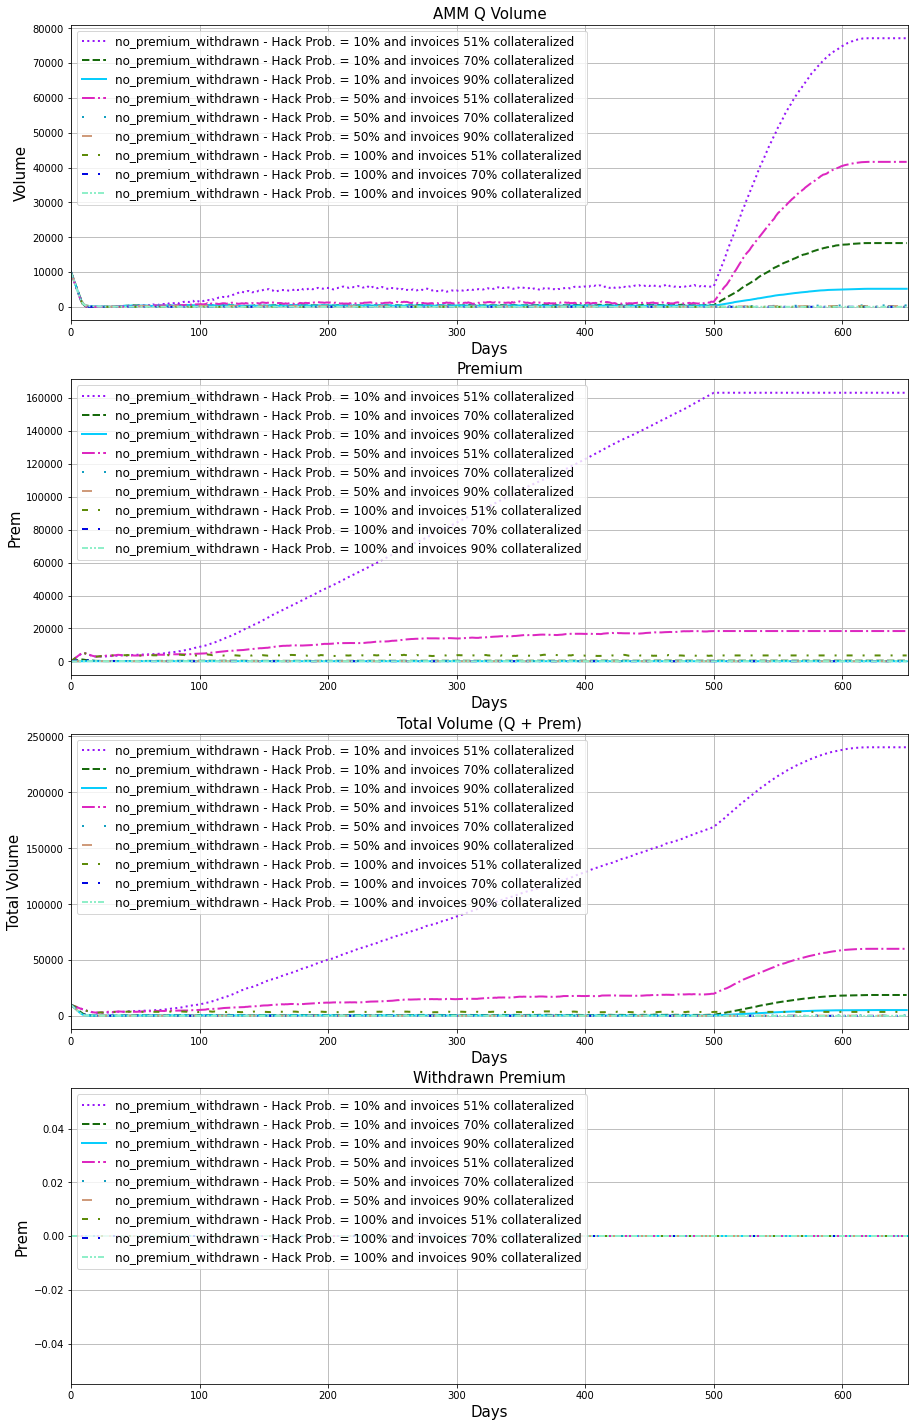

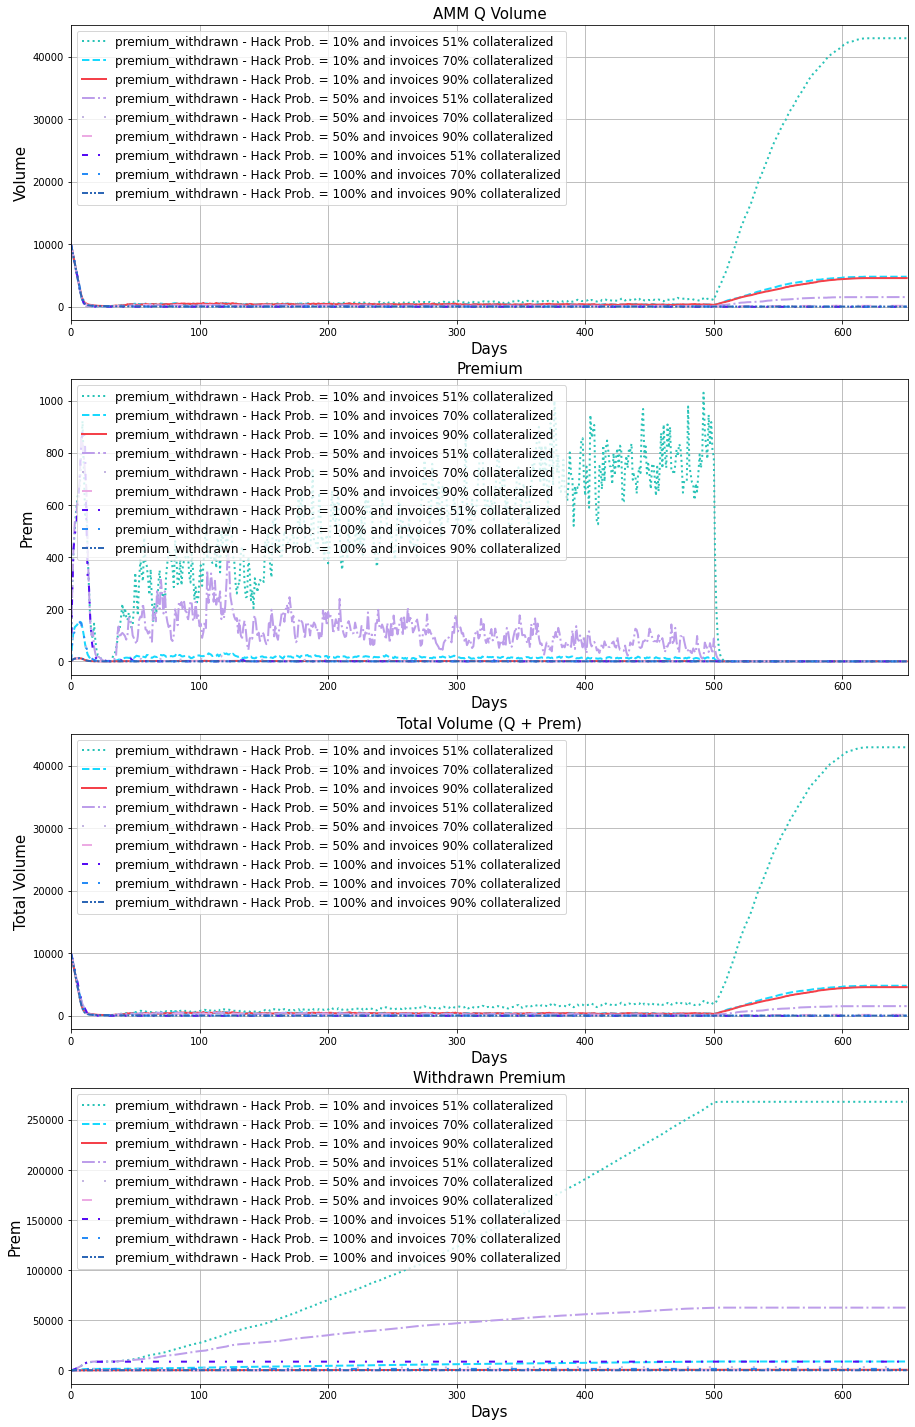

In [16]:
def aux_hack_scenario(list_values):

    cases_array = {}

    for index, i in enumerate(list_values):
        hack_scenario(i[0], i[1])

        cases_array[index] = result()

    for j, sim_name in enumerate(sim_type):
        
        ax, ax2, ax3, ax4, y = aux_plot()

        for index, i in enumerate(list_values):

            arrays_values = cases_array[index]

            q_volume_values = arrays_values[0]
            prem_values = arrays_values[1]
            volume_values = arrays_values[2]
            accu_prem_values = arrays_values[3]

            curve_color = (random.uniform(0,1), random.uniform(0,1), random.uniform(0,1))
            linestyles = ['dotted', 'dashed', 'solid', 'dashdot', (0, (1,10)), (0,(5,10)), (0, (3,5,1,5)), (0, (3,5,1,5,1,5)), (0, (3,1,1,1,1,1))]

            label_value = f"{sim_name} - Hack Prob. = {int(i[0]*100)}% and invoices {int(i[1]*100)}% collateralized"

            ax.plot(y, q_volume_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=curve_color, label = label_value)
            ax.legend(loc="upper left", prop = {'size': 12})
            ax.grid()

            ax2.plot(y, prem_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=curve_color, label = label_value)
            ax2.legend(loc="upper left", prop = {'size': 12})
            ax2.grid()

            ax3.plot(y, volume_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=curve_color, label = label_value)
            ax3.legend(loc="upper left", prop = {'size': 12})
            ax3.grid()

            ax4.plot(y, accu_prem_values[j], linewidth=2, linestyle=linestyles[list_values.index(i)], color=curve_color, label = label_value)
            ax4.legend(loc="upper left", prop = {'size': 12})
            ax4.grid()

    plt.show()

aux_hack_scenario(values_hack_scenario)
reset()